# Stochastic Collocation for Uncertainty Quantification in Elliptic Model Problems
This notebook demonstrates the use of Stochastic Collocation for Uncertainty Quantification in the following elliptic model problem. Specifically, we consider the elliptic model problem defined on $\Omega = (0,1)$ with boundary $\partial \Omega = \Gamma_N \cup \Gamma_D$ and $x = (x_1 , x_2)$.

\begin{equation}
    \left\{
    \begin{aligned}
        \operatorname{div} \left( \kappa(\xi,x) \nabla u(\xi,x) \right) &= 0 && \text{ for } (\xi,x) \in \Xi \times \Omega \\
        u(\xi,x) &= u_D && \text{ on } \Gamma_D \\
        \kappa(\xi,x) \nabla u(\xi,x) \cdot n &= g_N && \text{ on } \Gamma_N
    \end{aligned}
    \right.
\end{equation}

The boundary conditions are defined as follows:
- $\Gamma_D = \{(x,y) \in \overline{\Omega} \mid y = 0\}$
- $u_D 	\equiv 0$
- $\Gamma_N  = \partial \Omega \setminus \Gamma_D$
- $g_N = \begin{cases} 
            0 & \text{if } (x,y) \in \{(x,y) \in \Gamma_N : x \in \{0,1\}\} \\
            -1 & \text{otherwise}
            \end{cases}$

This setup allows us to analyze the impact of uncertainties in the model parameters $\kappa(\xi,x)$ on the solution $u(\xi,x)$.


### Solving the Numerical Problem
To solve the numerical problem, we use the finite element software [M++](https://www.math.kit.edu/ianm3/seite/mplusplus/en). By default, this software employs first-degree basis functions and uses a regular decomposition of the domain $\Omega$ into quadrilateral elements.

For generating $\kappa$ as a lognormal field, we use a truncated Karhunen–Loève (KL) expansion. The covariance kernel is defined by
\begin{equation*}
    C(x,y) = \sigma^2 \exp\left(\frac{- \|x-y\|_{p}^{\alpha}}{\lambda^{\alpha}}\right).
\end{equation*}
The parameters are initially set to $\sigma = 1$, $\lambda = 1$, $\alpha = 1$, and $p = 2$.


### Stochastic Collocation with Sparse Grid Quadrature for Uncertainty Quantification
We aim to quantify the global behavior of the numerical solution $u$ under uncertainty using stochastic methods. To achieve this, we employ sparse grid quadrature for calculating the stochastic integrals required to compute the expected value
\begin{equation*}
    \mathbb{E} \left[ \left\|u(\xi, x) \right\|_{L^2(\Omega)} \right] = \int_{\Xi} \left\|u(\xi, x) \right\|_{L^2(\Omega)} \, \mathrm{d}\mathbb{P}(\xi),
\end{equation*}
as well as the variance
\begin{equation*}
    \operatorname{Var}\left[\left\|u(\xi, x) \right\|_{L^2(\Omega)} \right] = \mathbb{E} \left[ \left( \left\|u(\xi, x) \right\|_{L^2(\Omega)} - \mathbb{E} \left[ \left\|u(\xi, x) \right\|_{L^2(\Omega)} \right]  \right)^2 \right].
\end{equation*}

To quantify the stochastic error, we use the Root Mean Square Error (RMSE)
\begin{equation*}
    \operatorname{RMSE}(\hat{Q}) = \left(\mathbb{E} \left[ (\hat{Q}- \mathbb{E} \left[ Q \right])^2 \right] \right)^{\frac{1}{2}}.
\end{equation*}

The sparse grid quadrature is implemented using the Tasmanian package ([Tasmanian GitHub](https://github.com/ORNL/TASMANIAN)) with the Clenshaw-Curtis rule.


### Comparison with the Monte Carlo Method
To obtain comparison values, the sparse grid quadrature is compared with the Monte Carlo method for calculating the stochastic integrals.

# Installation of M++

In [1]:
import sys
# Append the parent directory to the system path
sys.path.append('../..')

# Import necessary libraries
import python.mppy as mppy
import numpy as np
from plotting import *
import pandas as pd
import matplotlib.pyplot as plt
import timeit
import tikzplotlib
from tqdm import tqdm
from datetime import datetime
import pickle

# Initialize the M++ wrapper with 4 kernels, not muted, and set the executable to 'M++'
mpp = mppy.Mpp(kernels=4,
               mute=False,
               executable='M++',
               # project_name='tutorial',  # Optional: specify project name
               # build_dir='build_scc',    # Optional: specify a different build directory
               build_dir='build',          # Set the build directory
               cmake_args = ['-DBUILD_TUTORIAL=ON'])  # Pass CMake arguments to build tutorial

# Clean previous data
mpp.clean_data()
# Build the project
mpp.build()



================ running cmake ================

-- PROJECT_BINARY_DIR= /home/philipp/Bachelorarbeit/mpp/build
-- PROJECT_SOURCE_DIR= /home/philipp/Bachelorarbeit/mpp
-- PROJECT_MPP_DIR=    /home/philipp/Bachelorarbeit/mpp
-- Option:     BUILD_UQ= ON   (using cached value)
-- Option:     USE_FFTW= ON   (using cached value)
-- Option:     USE_SPLITTED_COMMS= ON   (using cached value)
-- Option:     AFFINE_LINEAR_TRAFO= ON   (using cached value)
-- Option:     BUILD_TUTORIAL= ON   (using cached value)
-- Option:     MPP_BUILD_TYPE= MppRelease   (using cached value)
-- Option:     DEBUG_LEVEL= 1   (using cached value)
-- Option:     CPP_VERSION= 20   (using cached value)
-- Option:     CMAKE_CXX_STANDARD=    (using cached value)
-- Option:     CPP_COMPILER_TYPE= c++   (using cached value)
-- Option:     SUPPRESS_WARNINGS= OFF   (using cached value)
-- Option:     BUILD_TESTS= OFF   (using cached value)
-- Option:     CONST_GEOMETRIC_TOLERANCE= 1e-10   (using cached value)
-- Option:     

0

# Method to evaluate M++ data into DataFrames

In [2]:
# Ammount of SparseGrid points to set the number of Monte-Carlo samples.
sparse_grid_points = {
    '↓level\Trunc->': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    1: [3, 5, 9, 17, 33, 65, 129, 257, 513, 1025],
    2: [5, 13, 29, 65, 145, 321, 705, 1537, 3329, 7169],
    3: [7, 25, 69, 177, 441, 1073, 2561, 6017, 13953, 32001],
    4: [9, 41, 137, 401, 1105, 2929, 7537, 18945, 46721, 113409],
    5: [11, 61, 241, 801, 2433, 6993, 19313, 51713, 135073, 345665],
    6: [13, 85, 389, 1457, 4865, 15121, 44689, 127105, 350657, 943553],
    7: [15, 113, 589, 2465, 9017, 30241, 95441, 287745, 836769, 2362881],
    8: [17, 145, 849, 3937, 15713, 56737, 190881, 609025, 1863937, 5515265],
    9: [19, 181, 1177, 6001, 26017, 100897, 361249, 1218049, 3918273, 12133761],
    10: [21, 221, 1581, 8801, 41265, 171425, 652065, 2320385, 7836545, 25370753],
    20: [41, 841, 11561, 120401, 1018129, 7314609, 46106289, 0, 0, 0]
}

def eval_mpp_data(SampleMethod, trunc_values, stoch_levels, degree, space_level):
    """
    This function evaluates MPP data for given truncation values and stochastic levels, 
    running the MPP simulation and parsing the results into a DataFrame.

    Parameters:
    SampleMethod (string): SC or MC.
    trunc_values (list): A list of truncation values to be used in the simulation.
    stoch_levels (list): A list of stochastic levels to be used in the simulation.
    degree (int): The degree to be used in the simulation.
    space_level (int): The space level to be used in the simulation.

    Returns:
    pd.DataFrame: A DataFrame containing the results of the MPP simulation with columns:
                  "Estimator", "trunc", "stochLevel", "Samples", "Mean", "sVar", "MSE", "RMSE" and "Cost".
    """
    mpp.mute = True
    mpp.reset_data()

    # Define columns for the DataFrame
    columns = [
        "Estimator",
        "trunc",
        "stochLevel",
        "Samples",
        "Value",
        "sVar",
        "MSE",
        "RMSE",
        "Cost"
    ]

    # Iterate over truncation values
    for trunc in trunc_values:
        print("SpaceLevel=", space_level, "Trunc=", trunc, "Start")

        # Iterate over stochastic levels
        for L in tqdm(stoch_levels):
            kwargs = {"degree": degree,
                  "SampleMethod": SampleMethod,
                  "Estimator": SampleMethod,
                  "Level":space_level,
                  "level":space_level,
                  "Samples":sparse_grid_points[trunc][L-1],
                  "trunc":trunc,
                  "stochLevel": L,
                  "VtuPlot": 0 #Very important for computational time
                }
            mpp.run(1, config="SC_elliptic", kwargs=kwargs)
            mpp.parse_log()

        print("SpaceLevel=", space_level, "Trunc=", trunc, "Ende")
   
    # Create DataFrame from MPP data
    df = pd.DataFrame(mpp.data,columns=columns)
    df.rename(columns={'Value': 'Mean'}, inplace=True)

    # Replace arrays in 'sVar' column with the second-to-last element of each array
    df['sVar'] = df['sVar'].apply(lambda x: x[-2] if isinstance(x, list) and len(x) >= 3 else None)
        
    return df       

# Calculation of all required DataFrames for the first half of this notebook with M++ (optional)

The next cell is optional. Note that the computation can take more than 12 hours depending on the system due to the lack of parallelization.
All DataFrames can be immediately loaded from the respective files in the directory using the Python module Pickle in the following cell.

In [ ]:
# Calculations for different SpaceLevels

trunc_values = [1,2,3,4,5,6]
stoch_levels = [1,2,3,4,5,6,7]
degree = 1

# Starting time
start_time = datetime.now().time()
print("Started calculations for different SpaceLevels at:", start_time.strftime("%H:%M:%S"))

# Calculations for SpaceLevel=1. Only SC needed.
space_level = 1
df_sc_1 = eval_mpp_data("SC", trunc_values, stoch_levels, degree, space_level)
print("space level 1 done")
# Saving DataFrame (1)
file_path = 'DataFrames/df_sc_1.pickle'
with open(file_path, 'wb') as file:
    pickle.dump(df_sc_1, file)

# Calculations for SpaceLevel=2. Only SC needed.
space_level = 2
df_sc_2 = eval_mpp_data("SC", trunc_values, stoch_levels, degree, space_level)
print("space level 2 done")
# Saving DataFrame (2)
file_path = 'DataFrames/df_sc_2.pickle'
with open(file_path, 'wb') as file:
    pickle.dump(df_sc_2, file)

# Calculations for SpaceLevel=3. Only SC needed.
space_level = 3
df_sc_3 = eval_mpp_data("SC", trunc_values, stoch_levels, degree, space_level)
print("SC space level 3 done")
# Saving DataFrame (3)
file_path = 'DataFrames/df_sc_3.pickle'
with open(file_path, 'wb') as file:
    pickle.dump(df_sc_3, file)

# Calculations for SpaceLevel=4. Only SC needed.
space_level = 4
df_sc_4 = eval_mpp_data("SC", trunc_values, stoch_levels, degree, space_level)
print("SC space level 4 done")
# Saving DataFrame (4)
file_path = 'DataFrames/df_sc_4.pickle'
with open(file_path, 'wb') as file:
    pickle.dump(df_sc_4, file)

# Calculations for SpaceLevel=5. SC and MC.
space_level = 5
df_sc_5 = eval_mpp_data("SC", trunc_values, stoch_levels, degree, space_level)
print("SC space level 5 done")
df_mc_5 = eval_mpp_data("MC", trunc_values, stoch_levels, degree, space_level)
print("MC space level 5 done")
# Saving DataFrame (5)
file_path = 'DataFrames/df_sc_5.pickle'
with open(file_path, 'wb') as file:
    pickle.dump(df_sc_5, file)  
file_path = 'DataFrames/df_mc_5.pickle'
with open(file_path, 'wb') as file:
    pickle.dump(df_mc_5, file)

# Finish time
finish_time = datetime.now().time()
print("Finished calculations for different SpaceLevels at:", finish_time.strftime("%H:%M:%S"))

# Loading from files of required DataFrames for the first half of this notebook (optional)

To save computation time, all the required DataFrames can be loaded from the files in the next cell.

In [3]:
# Opening SpaceLevel=1 file
file_path = 'DataFrames/df_sc_1.pickle'
df_sc_1 = None
with open(file_path, 'rb') as file:
    # Deserialize and retrieve the variable from the file
    df_sc_1 = pickle.load(file)

# Opening SpaceLevel=2 file
file_path = 'DataFrames/df_sc_2.pickle'
df_sc_2 = None
with open(file_path, 'rb') as file:
    # Deserialize and retrieve the variable from the file
    df_sc_2 = pickle.load(file)

# Opening SpaceLevel=3 file
file_path = 'DataFrames/df_sc_3.pickle'
df_sc_3 = None
with open(file_path, 'rb') as file:
    # Deserialize and retrieve the variable from the file
    df_sc_3 = pickle.load(file)

# Opening SpaceLevel=4 file
file_path = 'DataFrames/df_sc_4.pickle'
df_sc_4 = None
with open(file_path, 'rb') as file:
    # Deserialize and retrieve the variable from the file
    df_sc_4 = pickle.load(file)

# Opening SpaceLevel=5 SC file
file_path = 'DataFrames/df_sc_5.pickle'
df_sc_5 = None
with open(file_path, 'rb') as file:
    # Deserialize and retrieve the variable from the file
    df_sc_5 = pickle.load(file)

# Opening SpaceLevel=5 MC file
file_path = 'DataFrames/df_mc_5.pickle'
df_mc_5 = None
with open(file_path, 'rb') as file:
    # Deserialize and retrieve the variable from the file
    df_mc_5 = pickle.load(file)

# Implemented plotting functions

In [4]:
# Global parameters
label_fontsize = 20
tick_fontsize = 16

def one_parameter_compare_stoch_level(df1, df2, parameter, space_level, trunc, plotname):
    """
    This function compares a specified parameter from two DataFrames (df1 and df2) across stochastic levels, 
    and generates a plot to visualize the comparison.

    Parameters:
    df1 (pd.DataFrame): The first DataFrame containing the data for SC.
    df2 (pd.DataFrame): The second DataFrame containing the data for MC.
    parameter (str): The parameter to be compared (e.g., 'Mean', 'RMSE', etc.).
    space_level (int): The space level used in the simulation.
    trunc (int): The truncation value used in the simulation.
    plotname (str): The name of the file where the plot will be saved.
    """
    

    # Filter DataFrames for the given truncation value
    df1_trunc = df1[df1['trunc'] == trunc]
    df2_trunc = df2[df2['trunc'] == trunc]

    # Extract stochastic levels and parameter values
    stoch_levels1 = np.array(df1_trunc['stochLevel'])
    parameter_values1 = np.array(df1_trunc[parameter])
        
    stoch_levels2 = np.array(df2_trunc['stochLevel'])
    parameter_values2 = np.array(df2_trunc[parameter])

    # Create a new figure for the plot
    plt.figure(figsize=(12, 8))

    # Plot the parameter values against stochastic levels for both DataFrames
    plt.plot(stoch_levels1, parameter_values1, marker='o', linestyle='-', label=f'SC trunc: {trunc}')
    plt.plot(stoch_levels2, parameter_values2, marker='x', linestyle='--', label=f'MC trunc: {trunc}')

    # Set labels and legend
    plt.xlabel('StochLevel', fontsize=label_fontsize)
    plt.ylabel(parameter, fontsize=label_fontsize)
    plt.legend(fontsize=label_fontsize)

    # Set tick parameters
    plt.xticks(stoch_levels1, fontsize=tick_fontsize)
    plt.yticks(fontsize=tick_fontsize)

    # Adjust y-axis offset text font size
    ax = plt.gca()
    ax.yaxis.get_offset_text().set_fontsize(tick_fontsize)

    # Enable grid for the plot
    plt.grid(True)

    # Save the plot to a file
    plt.savefig(plotname, dpi=500)

    # Display the plot
    plt.show()



def one_parameter_compare_sample_size(df1, df2, parameter, space_level, trunc, plotname):
    """
    This function compares a specified parameter from two DataFrames (df1 and df2) across sample sizes,
    and generates a plot to visualize the comparison.

    Parameters:
    df1 (pd.DataFrame): The first DataFrame containing the data for SC.
    df2 (pd.DataFrame): The second DataFrame containing the data for MC.
    parameter (str): The parameter to be compared (e.g., 'Mean', 'RMSE', etc.).
    space_level (int): The space level used in the simulation.
    trunc (int): The truncation value used in the simulation.
    plotname (str): The name of the file where the plot will be saved.
    """

    # Filter DataFrames for the given truncation value
    df1_trunc = df1[df1['trunc'] == trunc]
    df2_trunc = df2[df2['trunc'] == trunc]
    
    # Extract sample sizes and parameter values
    sample_sizes1 = np.array(df1_trunc['Samples'])
    parameter_values1 = np.array(df1_trunc[parameter])
    
    sample_sizes2 = np.array(df2_trunc['Samples'])
    parameter_values2 = np.array(df2_trunc[parameter])
    
    # Create a new figure for the plot
    plt.figure(figsize=(16, 8))
    
    # Plot the parameter values against sample sizes for both DataFrames
    plt.plot(sample_sizes1, parameter_values1, marker='o', linestyle='-', label=f'SC trunc: {trunc}')
    plt.plot(sample_sizes2, parameter_values2, marker='x', linestyle='--', label=f'MC trunc: {trunc}')
    
    # Set labels and legend
    plt.xlabel('Samples', fontsize=label_fontsize)
    plt.ylabel(parameter, fontsize=label_fontsize)
    plt.legend(fontsize=label_fontsize)
    
    # Set tick parameters
    plt.xticks(fontsize=tick_fontsize)
    plt.yticks(fontsize=tick_fontsize)
    
    # Adjust y-axis offset text font size
    ax = plt.gca()
    ax.yaxis.get_offset_text().set_fontsize(tick_fontsize)
    
    # Enable grid for the plot
    plt.grid(True)
    
    # Save the plot to a file
    plt.savefig(plotname, dpi=500)
    
    # Display the plot
    plt.show()



def one_parameter_stoch_level(df1, method, parameter, space_level, trunc, plotname):
    """
    This function plots a specified parameter from a DataFrame (df1) across stochastic levels,
    and generates a plot to visualize the trend for a given method.

    Parameters:
    df1 (pd.DataFrame): The DataFrame containing the data.
    method (str): The method used (e.g., 'SC', 'MC').
    parameter (str): The parameter to be plotted (e.g., 'Mean', 'RMSE', etc.).
    space_level (int): The space level used in the simulation.
    trunc (int): The truncation value used in the simulation.
    plotname (str): The name of the file where the plot will be saved.
    """
    
    label_fontsize = 20
    tick_fontsize = 16
    
    # Filter DataFrame for the given truncation value
    df1_trunc = df1[df1['trunc'] == trunc]
    
    # Extract stochastic levels and parameter values
    stoch_levels1 = np.array(df1_trunc['stochLevel'])
    parameter_values1 = np.array(df1_trunc[parameter])
    
    # Create a new figure for the plot
    plt.figure(figsize=(12, 8))
    
    # Plot the parameter values against stochastic levels
    plt.plot(stoch_levels1, parameter_values1, marker='o', linestyle='-', label=f'{method} trunc: {trunc}')
    
    # Set labels and legend
    plt.xlabel('StochLevel', fontsize=label_fontsize)
    plt.ylabel(parameter, fontsize=label_fontsize)
    plt.legend(fontsize=label_fontsize)
    
    # Set tick parameters
    plt.xticks(stoch_levels1, fontsize=tick_fontsize)
    plt.yticks(fontsize=tick_fontsize)
    
    # Adjust y-axis offset text font size
    ax = plt.gca()
    ax.yaxis.get_offset_text().set_fontsize(tick_fontsize)
    
    # Enable grid for the plot
    plt.grid(True)
    
    # Save the plot to a file
    plt.savefig(plotname, dpi=500)
    
    # Display the plot
    plt.show()



def one_parameter_sample_size(df1, method, parameter, space_level, trunc, plotname):
    """
    This function plots a specified parameter from a DataFrame (df1) across sample sizes,
    and generates a plot to visualize the trend for a given method.

    Parameters:
    df1 (pd.DataFrame): The DataFrame containing the data.
    method (str): The method used (e.g., 'SC', 'MC').
    parameter (str): The parameter to be plotted (e.g., 'Mean', 'RMSE', etc.).
    space_level (int): The space level used in the simulation.
    trunc (int): The truncation value used in the simulation.
    plotname (str): The name of the file where the plot will be saved.
    """
    
    label_fontsize = 20
    tick_fontsize = 16
    
    # Filter DataFrame for the given truncation value
    df1_trunc = df1[df1['trunc'] == trunc]
    
    # Extract sample sizes and parameter values
    sample_sizes1 = np.array(df1_trunc['Samples'])
    parameter_values1 = np.array(df1_trunc[parameter])
    
    # Create a new figure for the plot
    plt.figure(figsize=(12, 8))
    
    # Plot the parameter values against sample sizes
    plt.plot(sample_sizes1, parameter_values1, marker='o', linestyle='-', label=f'{method} trunc: {trunc}')
    
    # Set labels and legend
    plt.xlabel('Samples', fontsize=label_fontsize)
    plt.ylabel(parameter, fontsize=label_fontsize)
    plt.legend(fontsize=label_fontsize)
    
    # Set tick parameters
    plt.xticks(sample_sizes1, fontsize=tick_fontsize)
    plt.yticks(fontsize=tick_fontsize)
    
    # Adjust y-axis offset text font size
    ax = plt.gca()
    ax.yaxis.get_offset_text().set_fontsize(tick_fontsize)
    
    # Enable grid for the plot
    plt.grid(True)
    
    # Save the plot to a file
    plt.savefig(plotname, dpi=500)
    
    # Display the plot
    plt.show()

# Relation between RMSE and SpaceLevel for fixed truncation value 2

### Plot for all space levels

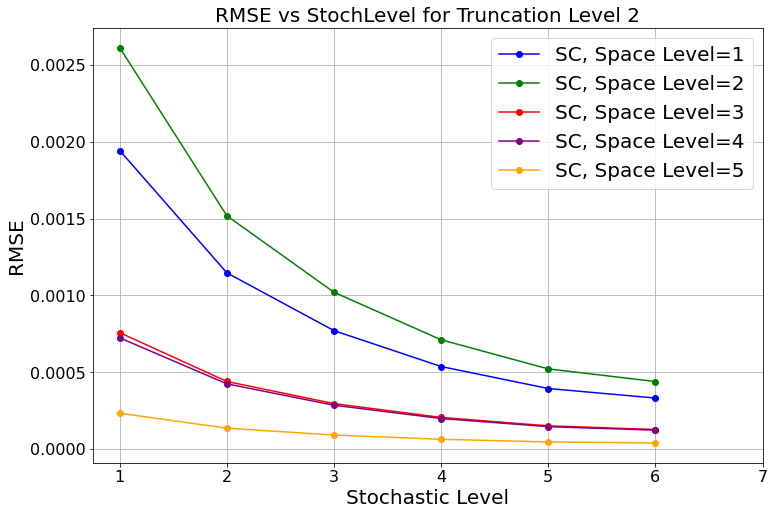

In [5]:
# Filter the DataFrames for trunc=2
df_sc_1_trunc2 = df_sc_1[df_sc_1['trunc'] == 2]
df_sc_2_trunc2 = df_sc_2[df_sc_2['trunc'] == 2]
df_sc_3_trunc2 = df_sc_3[df_sc_3['trunc'] == 2]
df_sc_4_trunc2 = df_sc_4[df_sc_4['trunc'] == 2]
df_sc_5_trunc2 = df_sc_5[df_sc_5['trunc'] == 2]

# Create plot
plt.figure(figsize=(12, 8))

# Plot for SpaceLevel=1
plt.plot(df_sc_1_trunc2['stochLevel'].values, df_sc_1_trunc2['RMSE'].values, label=f'SC, Space Level={1}', marker='o', color='blue')

# Plot for SpaceLevel=2
plt.plot(df_sc_2_trunc2['stochLevel'].values, df_sc_2_trunc2['RMSE'].values, label=f'SC, Space Level={2}', marker='o', color='green')

# Plot for SpaceLevel=3
plt.plot(df_sc_3_trunc2['stochLevel'].values, df_sc_3_trunc2['RMSE'].values, label=f'SC, Space Level={3}', marker='o', color='red')

# Plot for SpaceLevel=4
plt.plot(df_sc_4_trunc2['stochLevel'].values, df_sc_4_trunc2['RMSE'].values, label=f'SC, Space Level={4}', marker='o', color='purple')

# Plot for SpaceLevel=5
plt.plot(df_sc_5_trunc2['stochLevel'].values, df_sc_5_trunc2['RMSE'].values, label=f'SC, Space Level={5}', marker='o', color='orange')


plt.title(f'RMSE vs StochLevel for Truncation Level {2}', fontsize=label_fontsize)
plt.xlabel('Stochastic Level', fontsize=label_fontsize)
plt.ylabel('RMSE', fontsize=label_fontsize)
plt.legend(fontsize=label_fontsize)
plt.grid(True)
plt.xticks([1,2,3,4,5,6,7], fontsize=tick_fontsize)
plt.yticks(fontsize=tick_fontsize)
ax = plt.gca()
ax.yaxis.get_offset_text().set_fontsize(tick_fontsize)
plt.savefig("rmse_different_space_levels_trunc_2.png", dpi=500)
plt.show()

### Plot for last two space levels

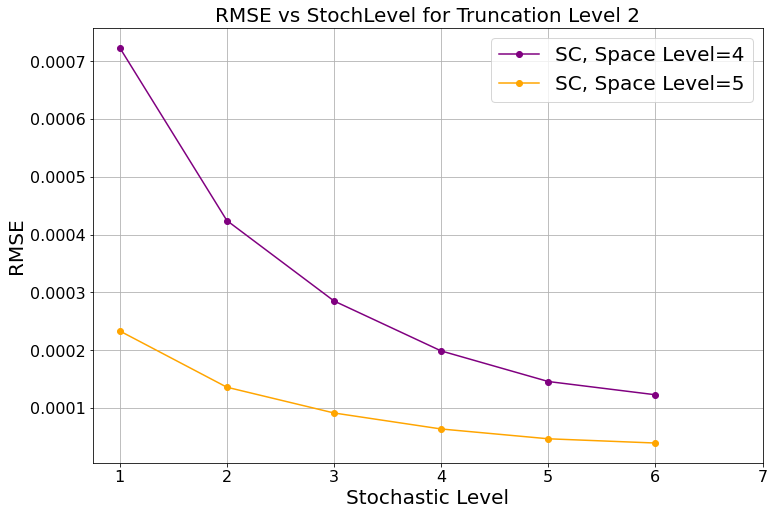

In [7]:
# Create Plot
plt.figure(figsize=(12, 8))

# Plot for SpaceLevel=4
plt.plot(df_sc_4_trunc2['stochLevel'].values, df_sc_4_trunc2['RMSE'].values, label=f'SC, Space Level={4}', marker='o', color='purple')

# Plot for SpaceLevel=5
plt.plot(df_sc_5_trunc2['stochLevel'].values, df_sc_5_trunc2['RMSE'].values, label=f'SC, Space Level={5}', marker='o', color='orange')



plt.title(f'RMSE vs StochLevel for Truncation Level {2}', fontsize=label_fontsize)
plt.xlabel('Stochastic Level', fontsize=label_fontsize)
plt.ylabel('RMSE', fontsize=label_fontsize)
plt.legend(fontsize=label_fontsize)
plt.grid(True)
plt.xticks([1,2,3,4,5,6,7], fontsize=tick_fontsize)
plt.yticks(fontsize=tick_fontsize)
ax = plt.gca()
ax.yaxis.get_offset_text().set_fontsize(tick_fontsize)
plt.savefig("rmse_last_two_space_levels_trunc_2.png", dpi=500)
plt.show()

# Relation between RMSE and SpaceLevel for fixed truncation value 4

### Plot for all space levels

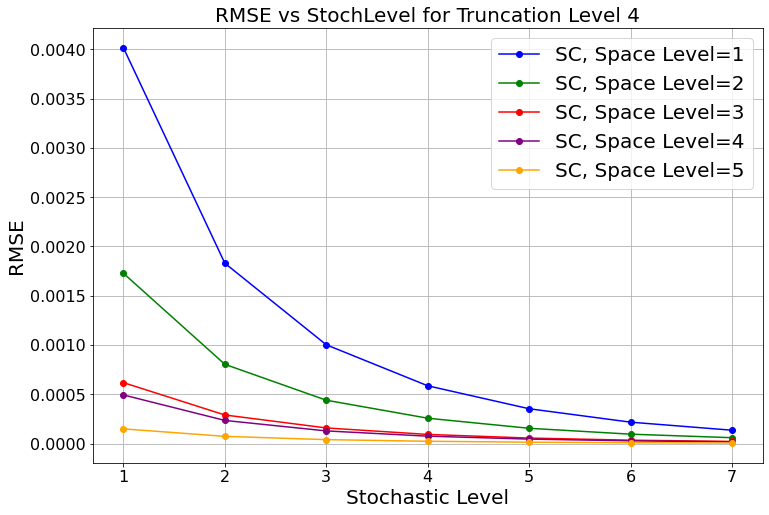

In [8]:
# Filter the DataFrames for trunc=4
df_sc_1_trunc4 = df_sc_1[df_sc_1['trunc'] == 4]
df_sc_2_trunc4 = df_sc_2[df_sc_2['trunc'] == 4]
df_sc_3_trunc4 = df_sc_3[df_sc_3['trunc'] == 4]
df_sc_4_trunc4 = df_sc_4[df_sc_4['trunc'] == 4]
df_sc_5_trunc4 = df_sc_5[df_sc_5['trunc'] == 4]

# Create plot
plt.figure(figsize=(12, 8))

# Plot for SpaceLevel=1
plt.plot(df_sc_1_trunc4['stochLevel'].values, df_sc_1_trunc4['RMSE'].values, label=f'SC, Space Level={1}', marker='o', color='blue')

# Plot for SpaceLevel=2
plt.plot(df_sc_2_trunc4['stochLevel'].values, df_sc_2_trunc4['RMSE'].values, label=f'SC, Space Level={2}', marker='o', color='green')

# Plot for SpaceLevel=3
plt.plot(df_sc_3_trunc4['stochLevel'].values, df_sc_3_trunc4['RMSE'].values, label=f'SC, Space Level={3}', marker='o', color='red')

# Plot for SpaceLevel=4
plt.plot(df_sc_4_trunc4['stochLevel'].values, df_sc_4_trunc4['RMSE'].values, label=f'SC, Space Level={4}', marker='o', color='purple')

# Plot for SpaceLevel=5
plt.plot(df_sc_5_trunc4['stochLevel'].values, df_sc_5_trunc4['RMSE'].values, label=f'SC, Space Level={5}', marker='o', color='orange')


plt.title(f'RMSE vs StochLevel for Truncation Level {4}', fontsize=label_fontsize)
plt.xlabel('Stochastic Level', fontsize=label_fontsize)
plt.ylabel('RMSE', fontsize=label_fontsize)
plt.legend(fontsize=label_fontsize)
plt.grid(True)
plt.xticks([1,2,3,4,5,6,7], fontsize=tick_fontsize)
plt.yticks(fontsize=tick_fontsize)
ax = plt.gca()
ax.yaxis.get_offset_text().set_fontsize(tick_fontsize)
plt.savefig("rmse_different_space_levels_trunc_4.png", dpi=500)
plt.show()

### Plot for last two space levels

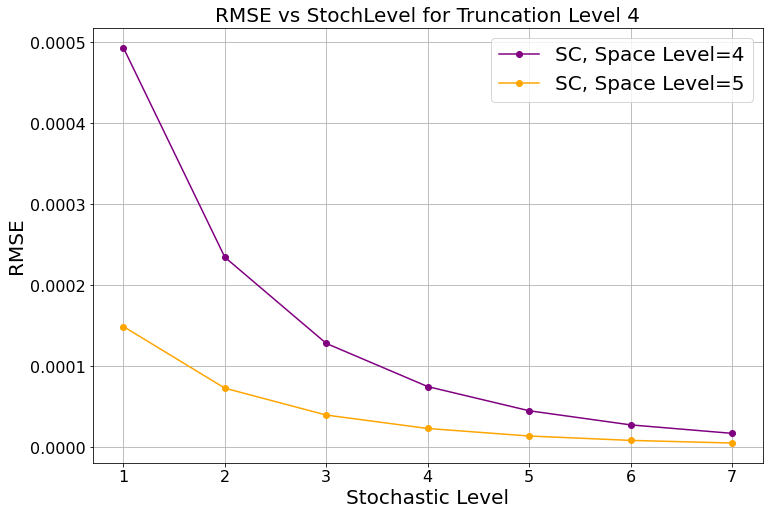

In [9]:
# Create plot
plt.figure(figsize=(12, 8))

# Plot for SpaceLevel=4
plt.plot(df_sc_4_trunc4['stochLevel'].values, df_sc_4_trunc4['RMSE'].values, label=f'SC, Space Level={4}', marker='o', color='purple')

# Plot for SpaceLevel=5
plt.plot(df_sc_5_trunc4['stochLevel'].values, df_sc_5_trunc4['RMSE'].values, label=f'SC, Space Level={5}', marker='o', color='orange')



plt.title(f'RMSE vs StochLevel for Truncation Level {4}', fontsize=label_fontsize)
plt.xlabel('Stochastic Level', fontsize=label_fontsize)
plt.ylabel('RMSE', fontsize=label_fontsize)
plt.legend(fontsize=label_fontsize)
plt.grid(True)
plt.xticks([1,2,3,4,5,6,7], fontsize=tick_fontsize)
plt.yticks(fontsize=tick_fontsize)
ax = plt.gca()
ax.yaxis.get_offset_text().set_fontsize(tick_fontsize)
plt.savefig("rmse_last_two_space_levels_trunc_4.png", dpi=500)
plt.show()

# Relation between RMSE and SpaceLevel for fixed truncation value 6

### Plot for all space levels

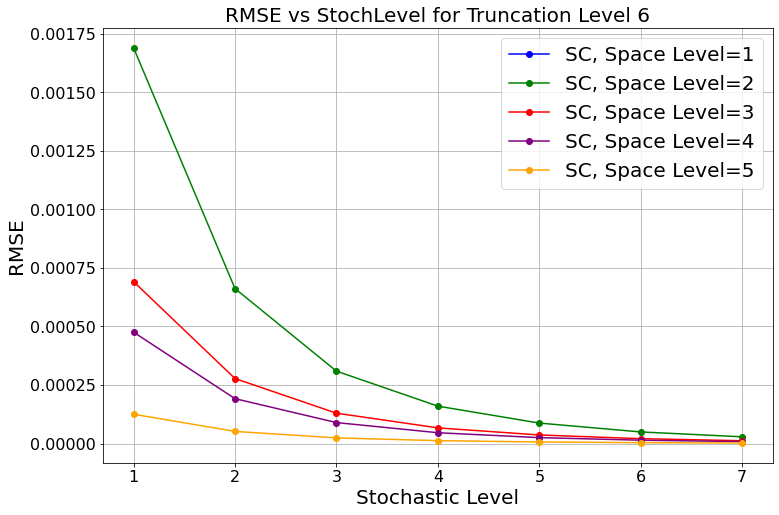

In [10]:
# Filter the DataFrames for trunc=6
df_sc_1_trunc6 = df_sc_1[df_sc_1['trunc'] == 6]
df_sc_2_trunc6 = df_sc_2[df_sc_2['trunc'] == 6]
df_sc_3_trunc6 = df_sc_3[df_sc_3['trunc'] == 6]
df_sc_4_trunc6 = df_sc_4[df_sc_4['trunc'] == 6]
df_sc_5_trunc6 = df_sc_5[df_sc_5['trunc'] == 6]

# Create plot
plt.figure(figsize=(12, 8))

# Plot for SpaceLevel=1
plt.plot(df_sc_1_trunc6['stochLevel'].values, df_sc_1_trunc6['RMSE'].values, label=f'SC, Space Level={1}', marker='o', color='blue')

# Plot for SpaceLevel=2
plt.plot(df_sc_2_trunc6['stochLevel'].values, df_sc_2_trunc6['RMSE'].values, label=f'SC, Space Level={2}', marker='o', color='green')

# Plot for SpaceLevel=3
plt.plot(df_sc_3_trunc6['stochLevel'].values, df_sc_3_trunc6['RMSE'].values, label=f'SC, Space Level={3}', marker='o', color='red')

# Plot for SpaceLevel=4
plt.plot(df_sc_4_trunc6['stochLevel'].values, df_sc_4_trunc6['RMSE'].values, label=f'SC, Space Level={4}', marker='o', color='purple')

# Plot for SpaceLevel=5
plt.plot(df_sc_5_trunc6['stochLevel'].values, df_sc_5_trunc6['RMSE'].values, label=f'SC, Space Level={5}', marker='o', color='orange')


plt.title(f'RMSE vs StochLevel for Truncation Level {6}', fontsize=label_fontsize)
plt.xlabel('Stochastic Level', fontsize=label_fontsize)
plt.ylabel('RMSE', fontsize=label_fontsize)
plt.legend(fontsize=label_fontsize)
plt.grid(True)
plt.xticks([1,2,3,4,5,6,7], fontsize=tick_fontsize)
plt.yticks(fontsize=tick_fontsize)
ax = plt.gca()
ax.yaxis.get_offset_text().set_fontsize(tick_fontsize)
plt.savefig("rmse_different_space_levels_trunc_6.png", dpi=500)
plt.show()

### Plot for last two space levels

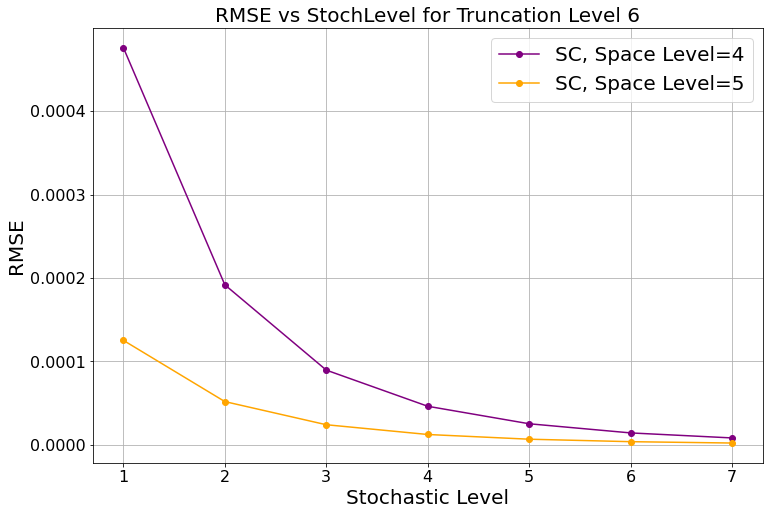

In [11]:
# Create plot
plt.figure(figsize=(12, 8))

# Plot for SpaceLevel=4
plt.plot(df_sc_4_trunc6['stochLevel'].values, df_sc_4_trunc6['RMSE'].values, label=f'SC, Space Level={4}', marker='o', color='purple')

# Plot for SpaceLevel=5
plt.plot(df_sc_5_trunc6['stochLevel'].values, df_sc_5_trunc6['RMSE'].values, label=f'SC, Space Level={5}', marker='o', color='orange')



plt.title(f'RMSE vs StochLevel for Truncation Level {6}', fontsize=label_fontsize)
plt.xlabel('Stochastic Level', fontsize=label_fontsize)
plt.ylabel('RMSE', fontsize=label_fontsize)
plt.legend(fontsize=label_fontsize)
plt.grid(True)
plt.xticks([1,2,3,4,5,6,7], fontsize=tick_fontsize)
plt.yticks(fontsize=tick_fontsize)
ax = plt.gca()
ax.yaxis.get_offset_text().set_fontsize(tick_fontsize)
plt.savefig("rmse_last_two_space_levels_trunc_6.png", dpi=500)
plt.show()

# Relation between MSE and SpaceLevel for fixed truncation value 6

### Plot for all space levels

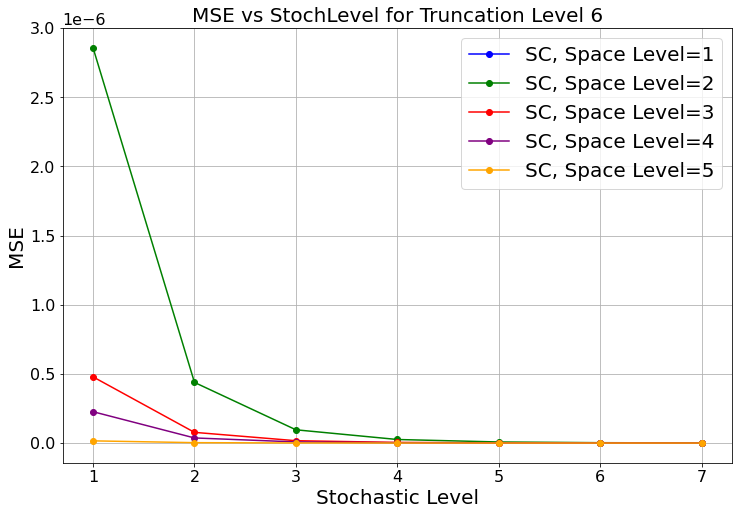

In [14]:
# Filter the DataFrames for trunc=6
df_sc_1_trunc6 = df_sc_1[df_sc_1['trunc'] == 6]
df_sc_2_trunc6 = df_sc_2[df_sc_2['trunc'] == 6]
df_sc_3_trunc6 = df_sc_3[df_sc_3['trunc'] == 6]
df_sc_4_trunc6 = df_sc_4[df_sc_4['trunc'] == 6]
df_sc_5_trunc6 = df_sc_5[df_sc_5['trunc'] == 6]


plt.figure(figsize=(12, 8))

# Plot for SpaceLevel=1
plt.plot(df_sc_1_trunc6['stochLevel'].values, df_sc_1_trunc6['MSE'].values, label=f'SC, Space Level={1}', marker='o', color='blue')

# Plot for SpaceLevel=2
plt.plot(df_sc_2_trunc6['stochLevel'].values, df_sc_2_trunc6['MSE'].values, label=f'SC, Space Level={2}', marker='o', color='green')

# Plot for SpaceLevel=3
plt.plot(df_sc_3_trunc6['stochLevel'].values, df_sc_3_trunc6['MSE'].values, label=f'SC, Space Level={3}', marker='o', color='red')

# Plot for SpaceLevel=4
plt.plot(df_sc_4_trunc6['stochLevel'].values, df_sc_4_trunc6['MSE'].values, label=f'SC, Space Level={4}', marker='o', color='purple')

# Plot for SpaceLevel=5
plt.plot(df_sc_5_trunc6['stochLevel'].values, df_sc_5_trunc6['MSE'].values, label=f'SC, Space Level={5}', marker='o', color='orange')


plt.title(f'MSE vs StochLevel for Truncation Level {6}', fontsize=label_fontsize)
plt.xlabel('Stochastic Level', fontsize=label_fontsize)
plt.ylabel('MSE', fontsize=label_fontsize)
plt.legend(fontsize=label_fontsize)
plt.grid(True)
plt.xticks([1,2,3,4,5,6,7], fontsize=tick_fontsize)
plt.yticks(fontsize=tick_fontsize)
ax = plt.gca()
ax.yaxis.get_offset_text().set_fontsize(tick_fontsize)
plt.savefig("mse_different_space_levels_trunc_6.png", dpi=500)
plt.show()

### Plot for last two space levels

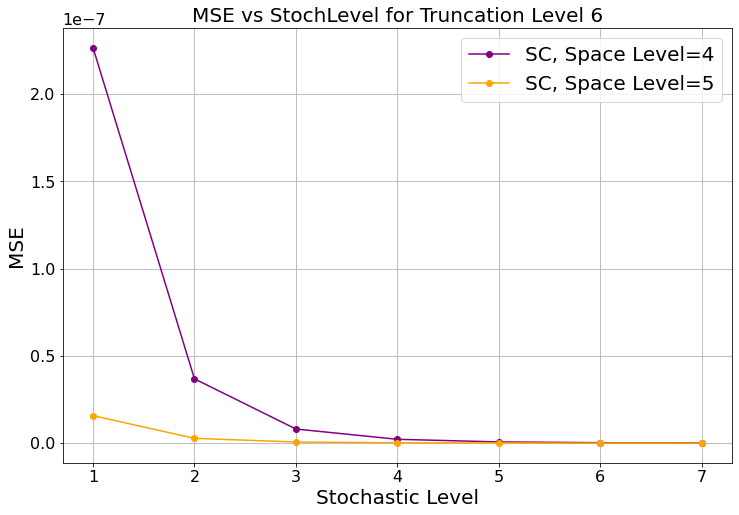

In [15]:
# Erstellen der Plots
plt.figure(figsize=(12, 8))

# Plot for SpaceLevel=4
plt.plot(df_sc_4_trunc6['stochLevel'].values, df_sc_4_trunc6['MSE'].values, label=f'SC, Space Level={4}', marker='o', color='purple')

# Plot for SpaceLevel=5
plt.plot(df_sc_5_trunc6['stochLevel'].values, df_sc_5_trunc6['MSE'].values, label=f'SC, Space Level={5}', marker='o', color='orange')



plt.title(f'MSE vs StochLevel for Truncation Level {6}', fontsize=label_fontsize)
plt.xlabel('Stochastic Level', fontsize=label_fontsize)
plt.ylabel('MSE', fontsize=label_fontsize)
plt.legend(fontsize=label_fontsize)
plt.grid(True)
plt.xticks([1,2,3,4,5,6,7], fontsize=tick_fontsize)
plt.yticks(fontsize=tick_fontsize)
ax = plt.gca()
ax.yaxis.get_offset_text().set_fontsize(tick_fontsize)
plt.savefig("mse_last_two_space_levels_trunc_6.png", dpi=500)
plt.show()

# Relation between RMSE and truncation for fixed SpaceLevel 5

### Plotting for all truncation values

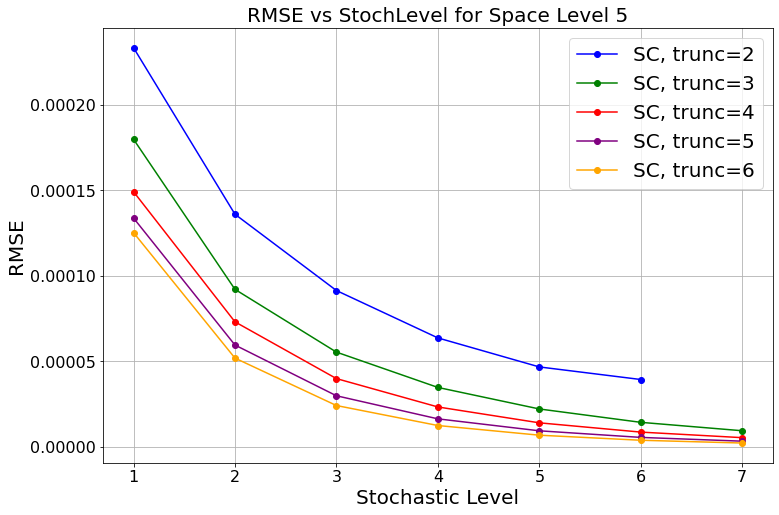

In [16]:
plt.figure(figsize=(12, 8))

# Colors
colors = ['blue', 'green', 'red', 'purple', 'orange']
short_trunc_values = [2, 3, 4, 5, 6]

for trunc, color in zip(short_trunc_values, colors):
    subset_1 = df_sc_5[df_sc_5['trunc'] == trunc]
    plt.plot(subset_1['stochLevel'].values, subset_1['RMSE'].values, label=f'SC, trunc={trunc}', marker='o', color=color)


plt.title(f'RMSE vs StochLevel for Space Level {5}', fontsize=label_fontsize)
plt.xlabel('Stochastic Level', fontsize=label_fontsize)
plt.ylabel('RMSE', fontsize=label_fontsize)
plt.legend(fontsize=label_fontsize)
plt.grid(True)
plt.xticks([1,2,3,4,5,6,7], fontsize=tick_fontsize)
plt.yticks(fontsize=tick_fontsize)
ax = plt.gca()
ax.yaxis.get_offset_text().set_fontsize(tick_fontsize)
plt.savefig("rmse_different_trunc_levels_space_5.png", dpi=500)
plt.show()

### Only plotting the last two truncation values

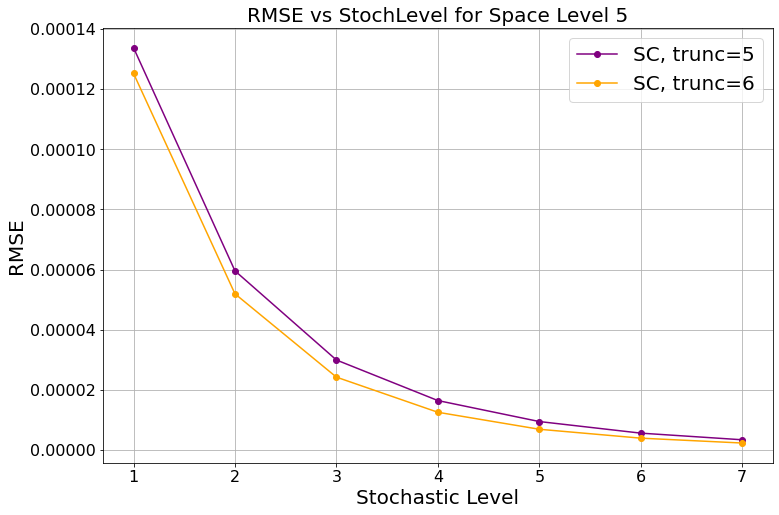

In [17]:
plt.figure(figsize=(12, 8))

# Colors
colors = ['purple', 'orange']
last_trunc = [short_trunc_values[-2], short_trunc_values[-1]]

for trunc, color in zip(last_trunc, colors):
    subset_1 = df_sc_5[df_sc_5['trunc'] == trunc]
    plt.plot(subset_1['stochLevel'].values, subset_1['RMSE'].values, label=f'SC, trunc={trunc}', marker='o', color=color)

plt.title(f'RMSE vs StochLevel for Space Level {5}', fontsize=label_fontsize)
plt.xlabel('Stochastic Level', fontsize=label_fontsize)
plt.ylabel('RMSE', fontsize=label_fontsize)
plt.legend(fontsize=label_fontsize)
plt.grid(True)
plt.xticks([1,2,3,4,5,6,7], fontsize=tick_fontsize)
plt.yticks(fontsize=tick_fontsize)
ax = plt.gca()
ax.yaxis.get_offset_text().set_fontsize(tick_fontsize)
plt.savefig("rmse_last_trunc_levels_space_5.png", dpi=500)
plt.show()

### Plotting for all truncation values (log scale)

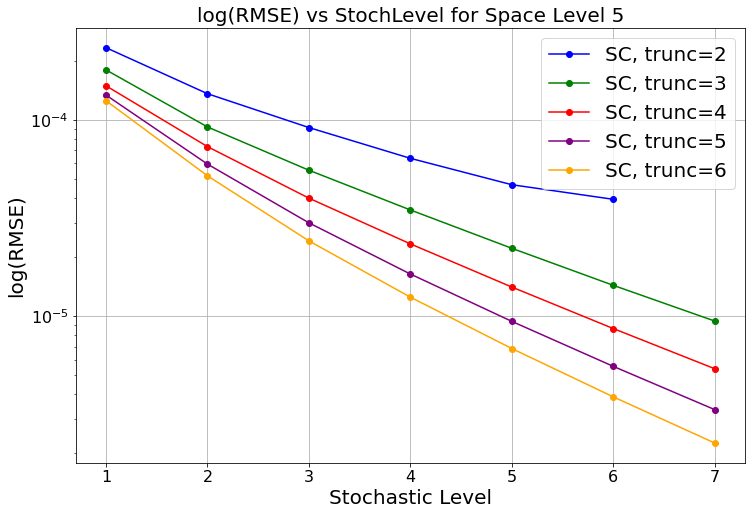

In [18]:
plt.figure(figsize=(12, 8))

# Colors
colors = ['blue', 'green', 'red', 'purple', 'orange']
short_trunc_values = [2, 3, 4, 5, 6]

for trunc, color in zip(short_trunc_values, colors):
    subset_1 = df_sc_5[df_sc_5['trunc'] == trunc]
    plt.plot(subset_1['stochLevel'].values, subset_1['RMSE'].values, label=f'SC, trunc={trunc}', marker='o', color=color)


plt.title(f'log(RMSE) vs StochLevel for Space Level {5}', fontsize=label_fontsize)
plt.xlabel('Stochastic Level', fontsize=label_fontsize)
plt.ylabel('log(RMSE)', fontsize=label_fontsize)
plt.legend(fontsize=label_fontsize)
plt.grid(True)
plt.xticks([1,2,3,4,5,6,7], fontsize=tick_fontsize)
plt.yticks(fontsize=tick_fontsize)
plt.yscale('log')
ax = plt.gca()
ax.yaxis.get_offset_text().set_fontsize(tick_fontsize)
plt.savefig("log_rmse_different_trunc_levels_space_5.png", dpi=500)
plt.show()

### Only plotting the last two truncation values (log scale)

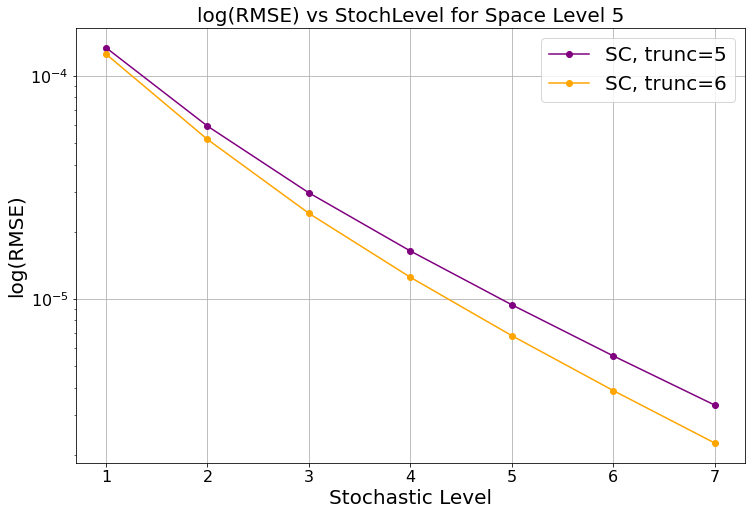

In [19]:
plt.figure(figsize=(12, 8))

# Colors
colors = ['purple', 'orange']
last_trunc = [short_trunc_values[-2], short_trunc_values[-1]]

for trunc, color in zip(last_trunc, colors):
    subset_1 = df_sc_5[df_sc_5['trunc'] == trunc]
    plt.plot(subset_1['stochLevel'].values, subset_1['RMSE'].values, label=f'SC, trunc={trunc}', marker='o', color=color)

plt.title(f'log(RMSE) vs StochLevel for Space Level {5}', fontsize=label_fontsize)
plt.xlabel('Stochastic Level', fontsize=label_fontsize)
plt.ylabel('log(RMSE)', fontsize=label_fontsize)
plt.legend(fontsize=label_fontsize)
plt.grid(True)
plt.xticks([1,2,3,4,5,6,7], fontsize=tick_fontsize)
plt.yticks(fontsize=tick_fontsize)
plt.yscale('log')
ax = plt.gca()
ax.yaxis.get_offset_text().set_fontsize(tick_fontsize)
plt.savefig("log_rmse_last_trunc_levels_space_5.png", dpi=500)
plt.show()

# Plotting of cost

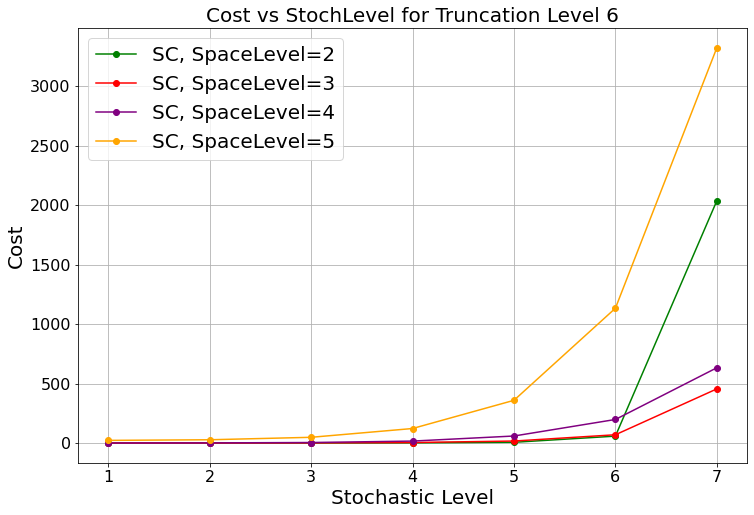

In [20]:
plt.figure(figsize=(12, 8))

# Colors
colors = ['blue', 'green', 'red', 'purple', 'orange']
trunc = 6

subset_2 = df_sc_2[df_sc_2['trunc'] == trunc]
plt.plot(subset_2['stochLevel'].values, subset_2['Cost'].values, label=f'SC, SpaceLevel={2}', marker='o', color=colors[1])

subset_3 = df_sc_3[df_sc_3['trunc'] == trunc]
plt.plot(subset_3['stochLevel'].values, subset_3['Cost'].values, label=f'SC, SpaceLevel={3}', marker='o', color=colors[2])

subset_4 = df_sc_4[df_sc_4['trunc'] == trunc]
plt.plot(subset_4['stochLevel'].values, subset_4['Cost'].values, label=f'SC, SpaceLevel={4}', marker='o', color=colors[3])

subset_5 = df_sc_5[df_sc_5['trunc'] == trunc]
plt.plot(subset_5['stochLevel'].values, subset_5['Cost'].values, label=f'SC, SpaceLevel={5}', marker='o', color=colors[4])



plt.title(f'Cost vs StochLevel for Truncation Level {6}', fontsize=label_fontsize)
plt.xlabel('Stochastic Level', fontsize=label_fontsize)
plt.ylabel('Cost', fontsize=label_fontsize)
plt.legend(fontsize=label_fontsize)
plt.grid(True)
plt.xticks([1,2,3,4,5,6,7], fontsize=tick_fontsize)
plt.yticks(fontsize=tick_fontsize)
ax = plt.gca()
ax.yaxis.get_offset_text().set_fontsize(tick_fontsize)
plt.savefig("cost_different_space_levels_trunc_6.png", dpi=500)
plt.show()

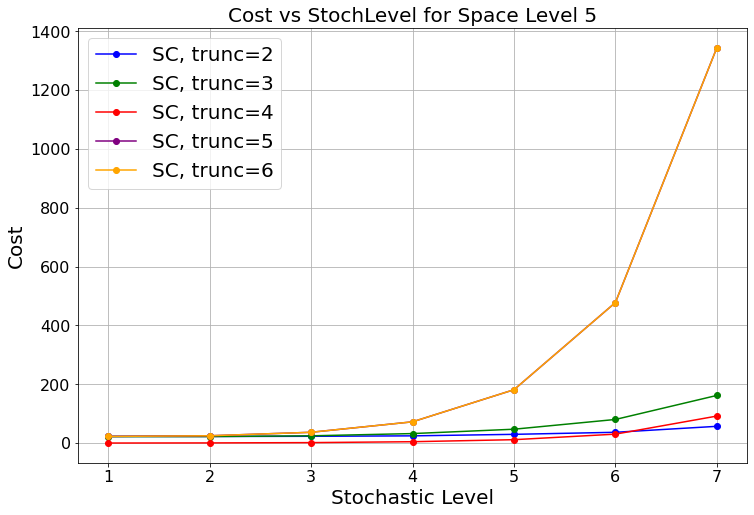

In [21]:
plt.figure(figsize=(12, 8))

# Colors
colors = ['blue', 'green', 'red', 'purple', 'orange']

subset_2 = df_sc_5[df_sc_5['trunc'] == 2]
plt.plot(subset_2['stochLevel'].values, subset_2['Cost'].values, label=f'SC, trunc={2}', marker='o', color=colors[0])

subset_3 = df_sc_5[df_sc_5['trunc'] == 3]
plt.plot(subset_3['stochLevel'].values, subset_3['Cost'].values, label=f'SC, trunc={3}', marker='o', color=colors[1])

subset_4 = df_sc_4[df_sc_4['trunc'] == 4]
plt.plot(subset_4['stochLevel'].values, subset_4['Cost'].values, label=f'SC, trunc={4}', marker='o', color=colors[2])

subset_5 = df_sc_5[df_sc_5['trunc'] == 5]
plt.plot(subset_5['stochLevel'].values, subset_5['Cost'].values, label=f'SC, trunc={5}', marker='o', color=colors[3])

subset_6 = df_sc_5[df_sc_5['trunc'] == 6]
plt.plot(subset_6['stochLevel'].values, subset_5['Cost'].values, label=f'SC, trunc={6}', marker='o', color=colors[4])




plt.title(f'Cost vs StochLevel for Space Level {5}', fontsize=label_fontsize)
plt.xlabel('Stochastic Level', fontsize=label_fontsize)
plt.ylabel('Cost', fontsize=label_fontsize)
plt.legend(fontsize=label_fontsize)
plt.grid(True)
plt.xticks([1,2,3,4,5,6,7], fontsize=tick_fontsize)
plt.yticks(fontsize=tick_fontsize)
ax = plt.gca()
ax.yaxis.get_offset_text().set_fontsize(tick_fontsize)
plt.savefig("cost_different_trunc_levels_space_5.png", dpi=500)
plt.show()

# Relation between Mean and Truncation for fixed SpaceLevel 3

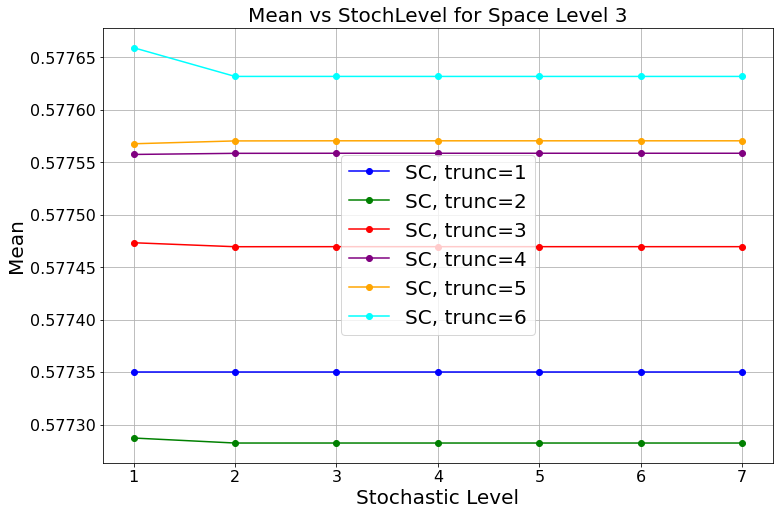

In [22]:
plt.figure(figsize=(12, 8))

# Colors
colors = ['blue', 'green', 'red', 'purple', 'orange', 'cyan']
trunc_values = [1, 2, 3, 4, 5, 6]

for trunc, color in zip(trunc_values, colors):
    subset_1 = df_sc_3[df_sc_3['trunc'] == trunc]
    plt.plot(subset_1['stochLevel'].values, subset_1['Mean'].values, label=f'SC, trunc={trunc}', marker='o', color=color)

plt.title(f'Mean vs StochLevel for Space Level {3}', fontsize=label_fontsize)
plt.xlabel('Stochastic Level', fontsize=label_fontsize)
plt.ylabel('Mean', fontsize=label_fontsize)
plt.legend(fontsize=label_fontsize)
plt.grid(True)
plt.xticks([1,2,3,4,5,6,7], fontsize=tick_fontsize)
plt.yticks(fontsize=tick_fontsize)
ax = plt.gca()
ax.yaxis.get_offset_text().set_fontsize(tick_fontsize)
plt.savefig("mean_different_trunc_levels_space_3.png", dpi=500)
plt.show()

# Relation between Mean and Truncation for fixed SpaceLevel 4

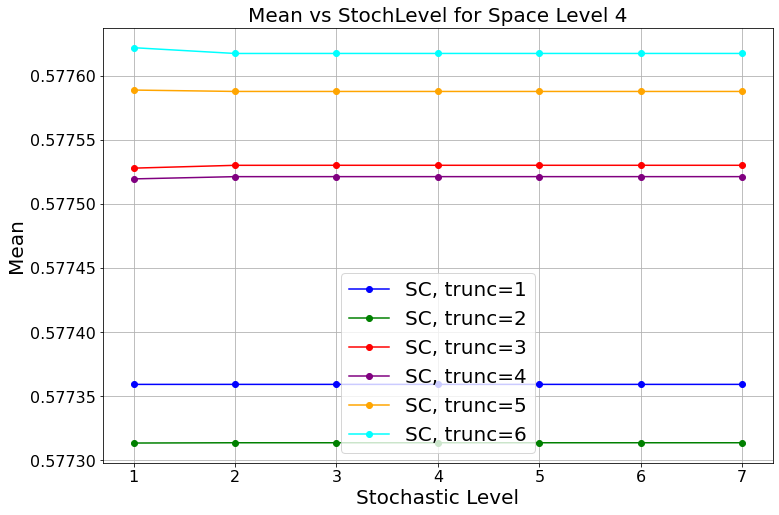

In [23]:
plt.figure(figsize=(12, 8))

# Colors
colors = ['blue', 'green', 'red', 'purple', 'orange', 'cyan']
trunc_values = [1, 2, 3, 4, 5, 6]

for trunc, color in zip(trunc_values, colors):
    subset_1 = df_sc_4[df_sc_4['trunc'] == trunc]
    plt.plot(subset_1['stochLevel'].values, subset_1['Mean'].values, label=f'SC, trunc={trunc}', marker='o', color=color)

plt.title(f'Mean vs StochLevel for Space Level {4}', fontsize=label_fontsize)
plt.xlabel('Stochastic Level', fontsize=label_fontsize)
plt.ylabel('Mean', fontsize=label_fontsize)
plt.legend(fontsize=label_fontsize)
plt.grid(True)
plt.xticks([1,2,3,4,5,6,7], fontsize=tick_fontsize)
plt.yticks(fontsize=tick_fontsize)
ax = plt.gca()
ax.yaxis.get_offset_text().set_fontsize(tick_fontsize)
plt.savefig("mean_different_trunc_levels_space_4.png", dpi=500)
plt.show()

# Relation between Mean and Truncation for fixed SpaceLevel 5

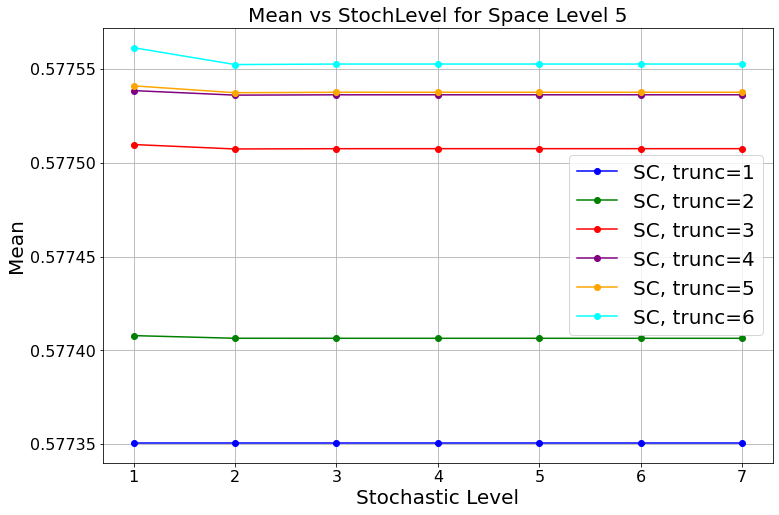

In [24]:
plt.figure(figsize=(12, 8))

# Colors
colors = ['blue', 'green', 'red', 'purple', 'orange', 'cyan']

for trunc, color in zip(trunc_values, colors):
    subset_1 = df_sc_5[df_sc_5['trunc'] == trunc]
    plt.plot(subset_1['stochLevel'].values, subset_1['Mean'].values, label=f'SC, trunc={trunc}', marker='o', color=color)

plt.title(f'Mean vs StochLevel for Space Level {5}', fontsize=label_fontsize)
plt.xlabel('Stochastic Level', fontsize=label_fontsize)
plt.ylabel('Mean', fontsize=label_fontsize)
plt.legend(fontsize=label_fontsize)
plt.grid(True)
plt.xticks([1,2,3,4,5,6,7], fontsize=tick_fontsize)
plt.yticks(fontsize=tick_fontsize)
ax = plt.gca()
ax.yaxis.get_offset_text().set_fontsize(tick_fontsize)
plt.savefig("mean_different_trunc_levels_space_5.png", dpi=500)
plt.show()

# Relation between sVar and Truncation for fixed SpaceLevel 2

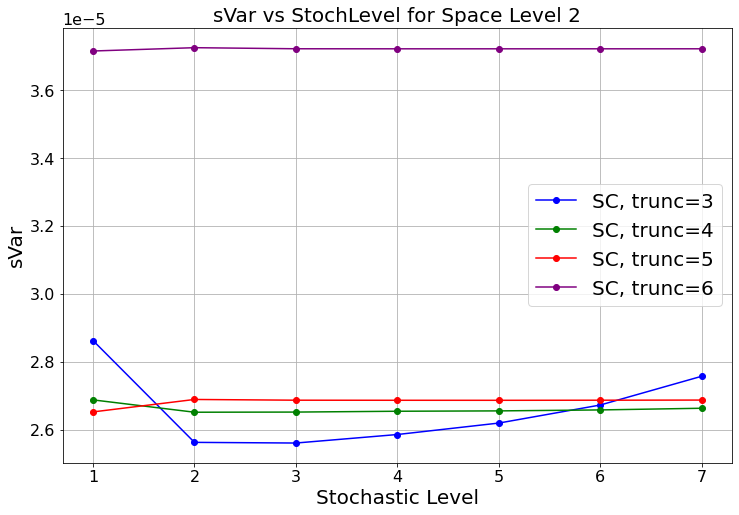

In [25]:
plt.figure(figsize=(12, 8))

trunc_values = [3,4,5,6]

for trunc, color in zip(trunc_values, colors):
    subset_1 = df_sc_2[df_sc_2['trunc'] == trunc]
    plt.plot(subset_1['stochLevel'].values, subset_1['sVar'].values, label=f'SC, trunc={trunc}', marker='o', color=color)

plt.title(f'sVar vs StochLevel for Space Level {2}', fontsize=label_fontsize)
plt.xlabel('Stochastic Level', fontsize=label_fontsize)
plt.ylabel('sVar', fontsize=label_fontsize)
plt.legend(fontsize=label_fontsize)
plt.grid(True)
plt.xticks([1,2,3,4,5,6,7], fontsize=tick_fontsize)
plt.yticks(fontsize=tick_fontsize)
ax = plt.gca()
ax.yaxis.get_offset_text().set_fontsize(tick_fontsize)

plt.savefig("sVar_different_trunc_levels_space_2.png", dpi=500)
plt.show()

# Relation between sVar and Truncation for fixed SpaceLevel 3

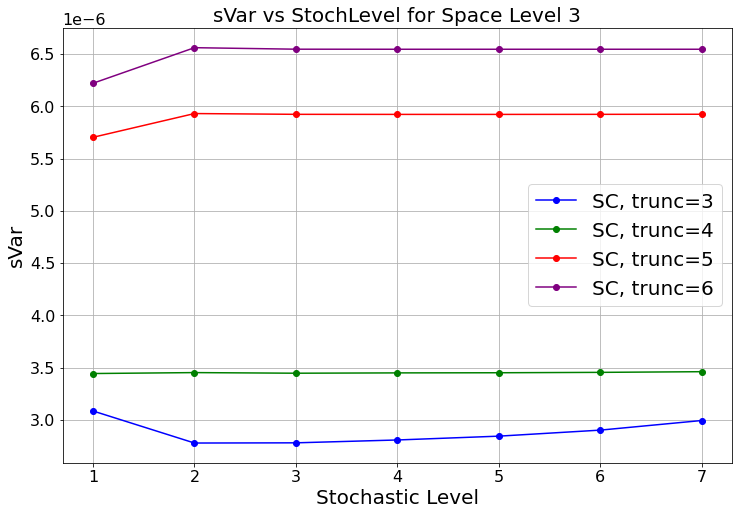

In [26]:
plt.figure(figsize=(12, 8))

trunc_values = [3,4,5,6]

for trunc, color in zip(trunc_values, colors):
    subset_1 = df_sc_3[df_sc_3['trunc'] == trunc]
    plt.plot(subset_1['stochLevel'].values, subset_1['sVar'].values, label=f'SC, trunc={trunc}', marker='o', color=color)

plt.title(f'sVar vs StochLevel for Space Level {3}', fontsize=label_fontsize)
plt.xlabel('Stochastic Level', fontsize=label_fontsize)
plt.ylabel('sVar', fontsize=label_fontsize)
plt.legend(fontsize=label_fontsize)
plt.grid(True)
plt.xticks([1,2,3,4,5,6,7], fontsize=tick_fontsize)
plt.yticks(fontsize=tick_fontsize)
ax = plt.gca()
ax.yaxis.get_offset_text().set_fontsize(tick_fontsize)
plt.savefig("sVar_different_trunc_levels_space_3.png", dpi=500)
plt.show()

# Relation between sVar and Truncation for fixed SpaceLevel 4

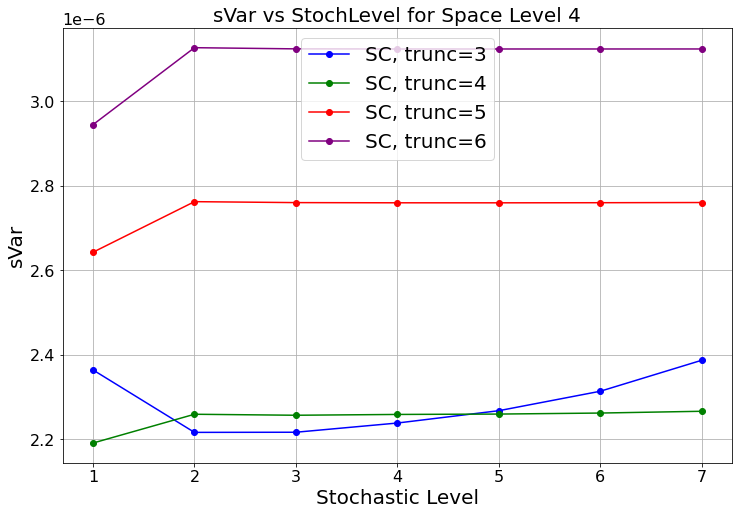

In [27]:
plt.figure(figsize=(12, 8))

trunc_values = [3,4,5,6]

for trunc, color in zip(trunc_values, colors):
    subset_1 = df_sc_4[df_sc_4['trunc'] == trunc]
    plt.plot(subset_1['stochLevel'].values, subset_1['sVar'].values, label=f'SC, trunc={trunc}', marker='o', color=color)

plt.title(f'sVar vs StochLevel for Space Level {4}', fontsize=label_fontsize)
plt.xlabel('Stochastic Level', fontsize=label_fontsize)
plt.ylabel('sVar', fontsize=label_fontsize)
plt.legend(fontsize=label_fontsize)
plt.grid(True)
plt.xticks([1,2,3,4,5,6,7], fontsize=tick_fontsize)
plt.yticks(fontsize=tick_fontsize)
ax = plt.gca()
ax.yaxis.get_offset_text().set_fontsize(tick_fontsize)
plt.savefig("sVar_different_trunc_levels_space_4.png", dpi=500)
plt.show()

# Relation between sVar and Truncation for fixed SpaceLevel 5

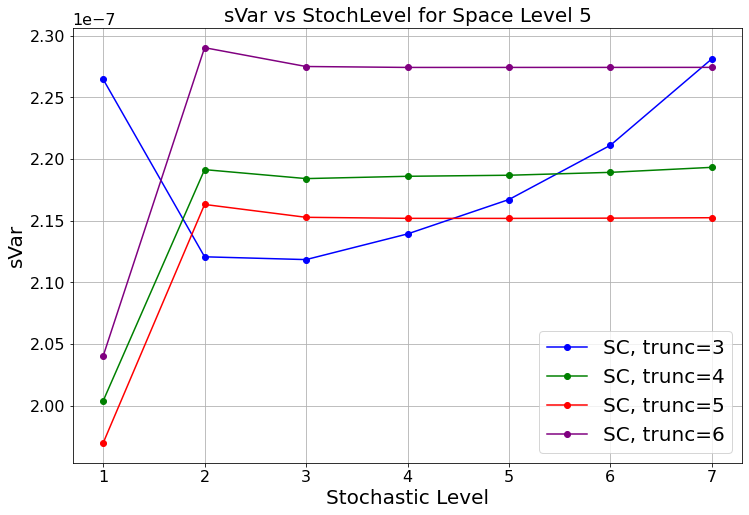

In [28]:
plt.figure(figsize=(12, 8))

trunc_values = [3,4,5,6]

for trunc, color in zip(trunc_values, colors):
    subset_1 = df_sc_5[df_sc_5['trunc'] == trunc]
    plt.plot(subset_1['stochLevel'].values, subset_1['sVar'].values, label=f'SC, trunc={trunc}', marker='o', color=color)

plt.title(f'sVar vs StochLevel for Space Level {5}', fontsize=label_fontsize)
plt.xlabel('Stochastic Level', fontsize=label_fontsize)
plt.ylabel('sVar', fontsize=label_fontsize)
plt.legend(fontsize=label_fontsize)
plt.grid(True)
plt.xticks([1,2,3,4,5,6,7], fontsize=tick_fontsize)
plt.yticks(fontsize=tick_fontsize)
ax = plt.gca()
ax.yaxis.get_offset_text().set_fontsize(tick_fontsize)
plt.savefig("sVar_different_trunc_levels_space_5.png", dpi=500)
plt.show()

# Comparison between SC and MC

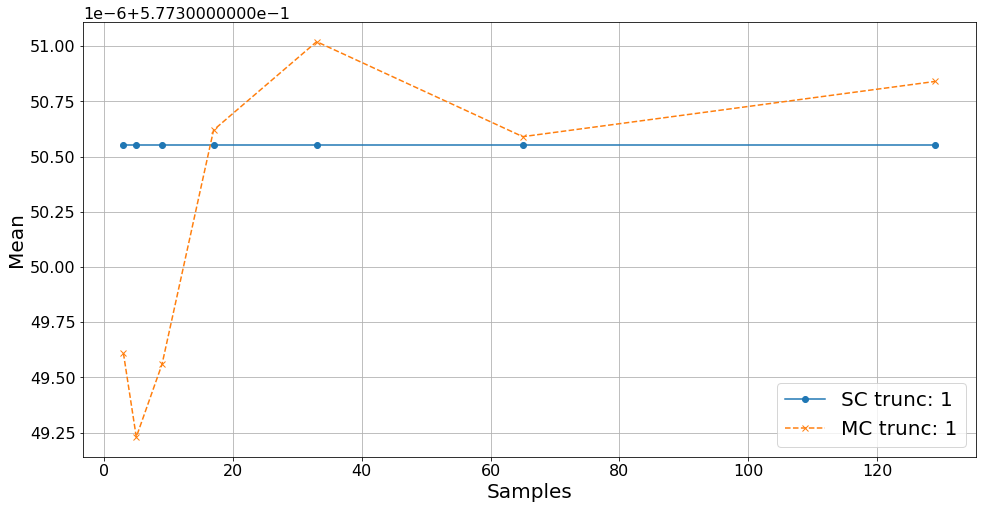

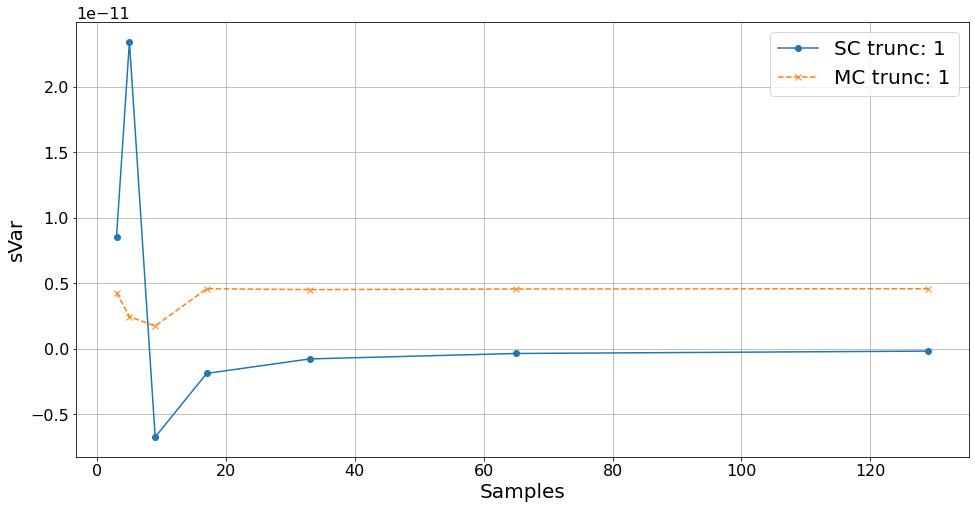

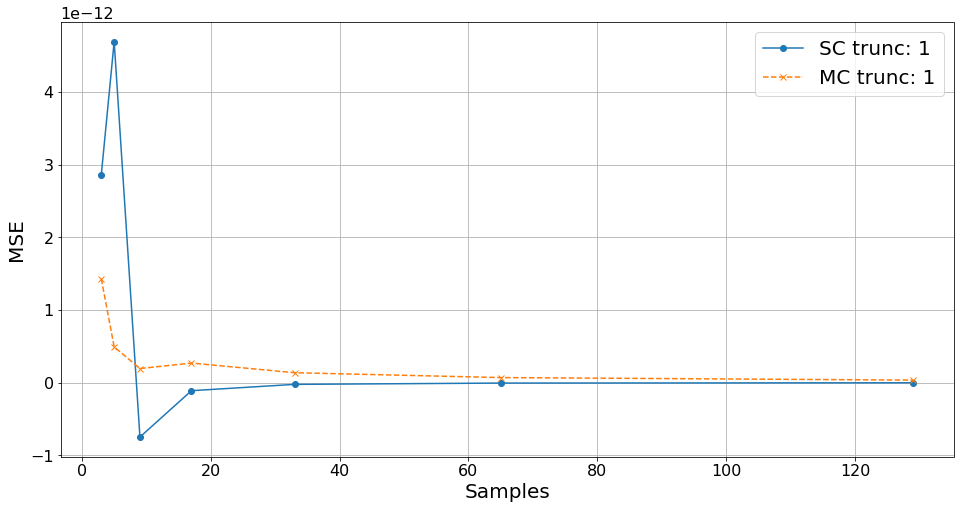

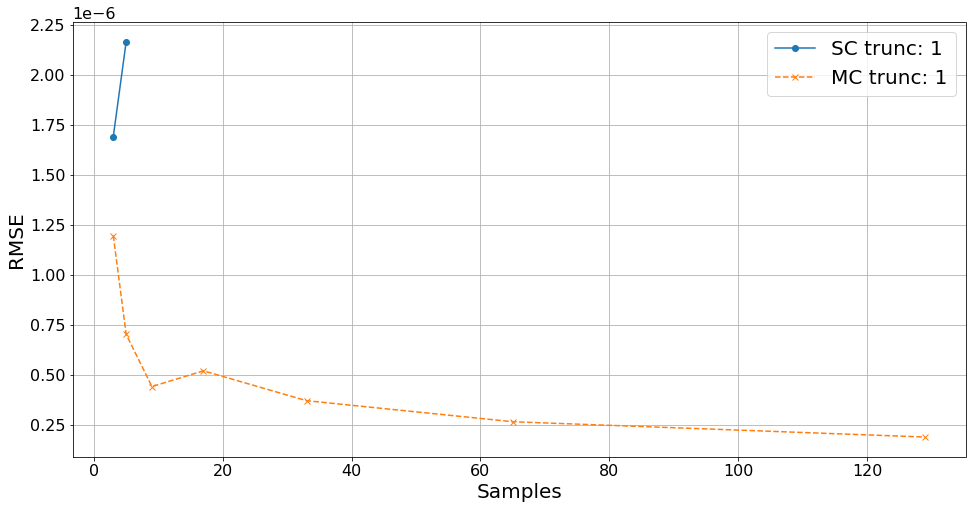

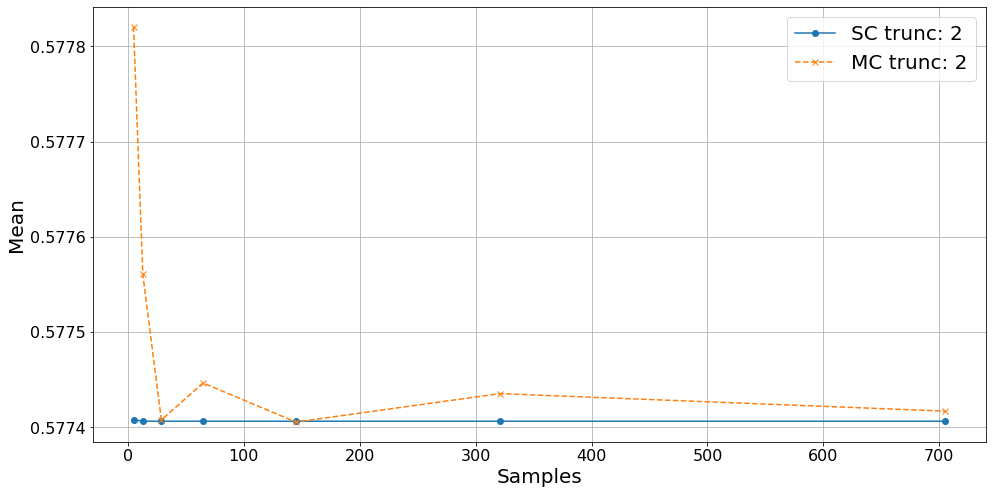

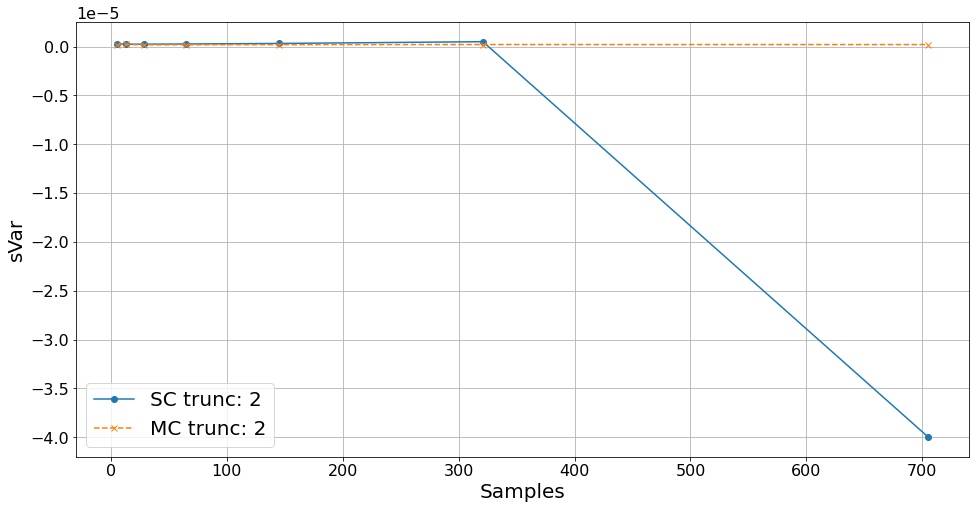

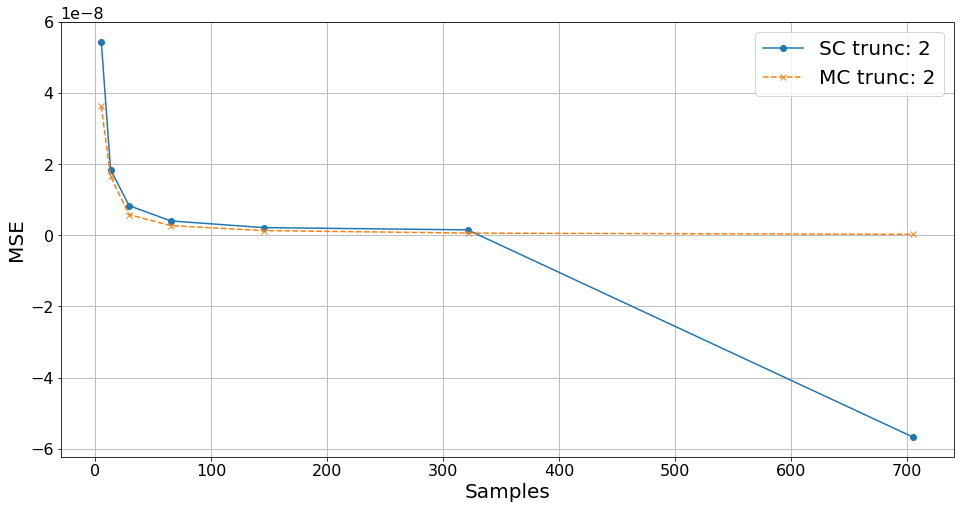

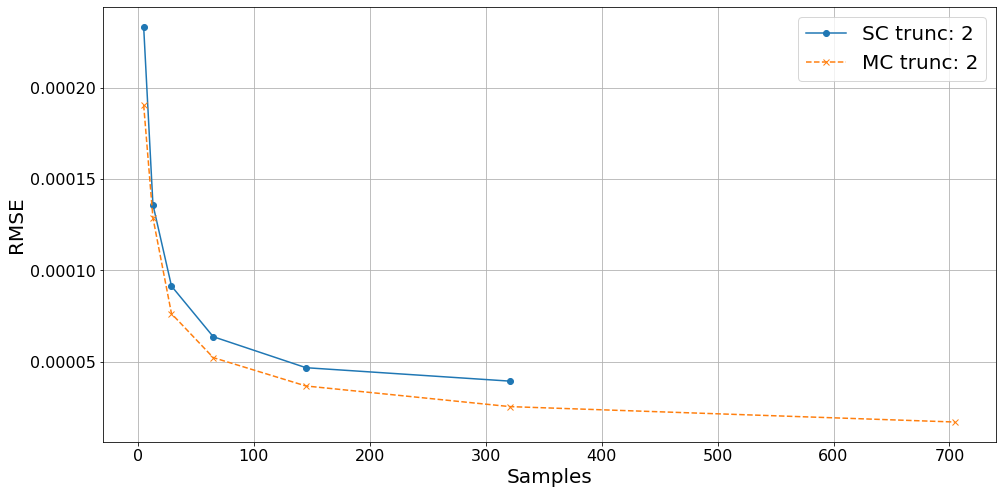

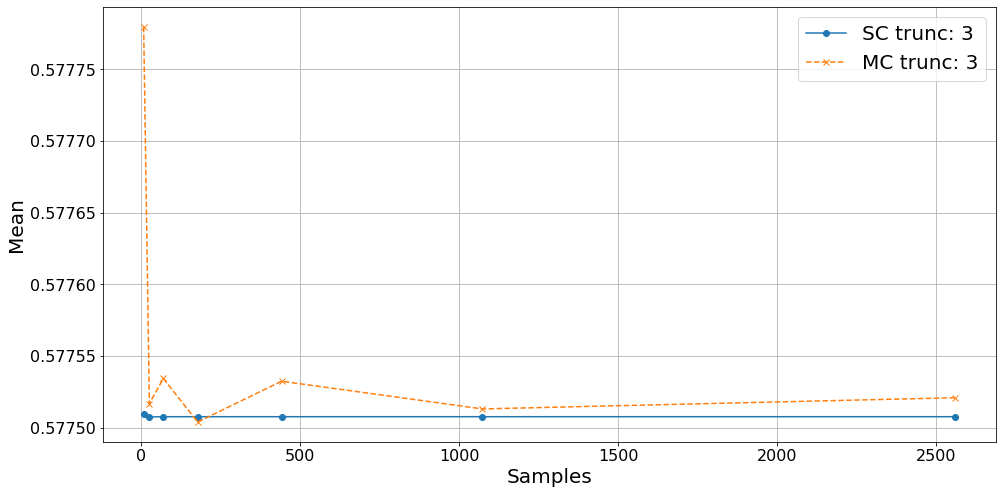

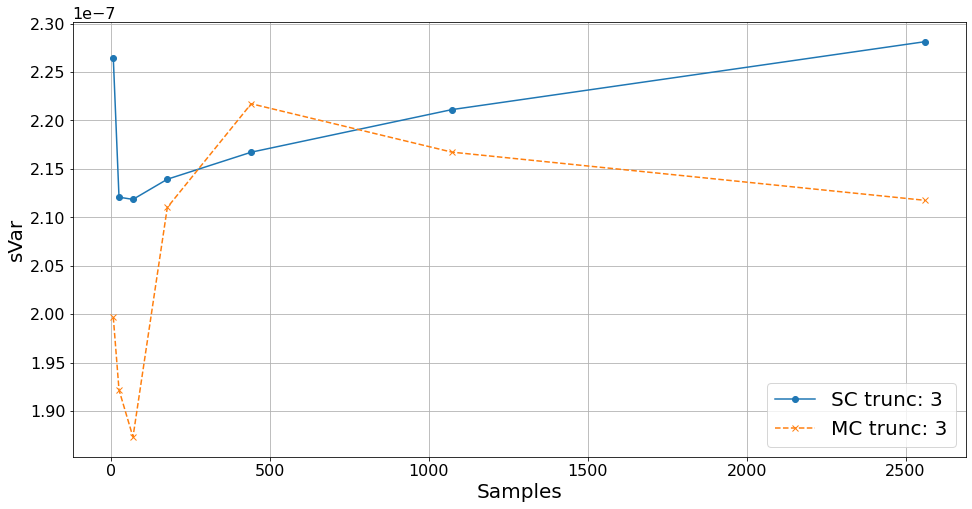

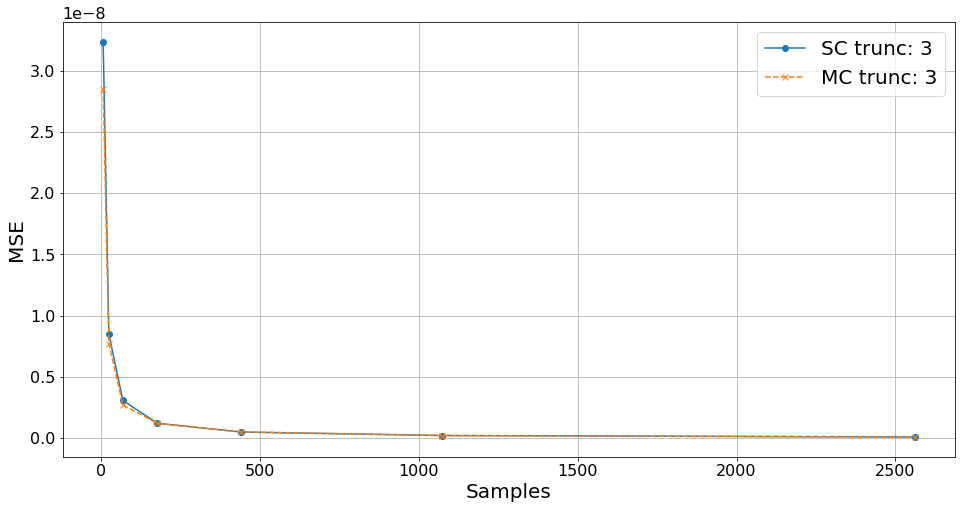

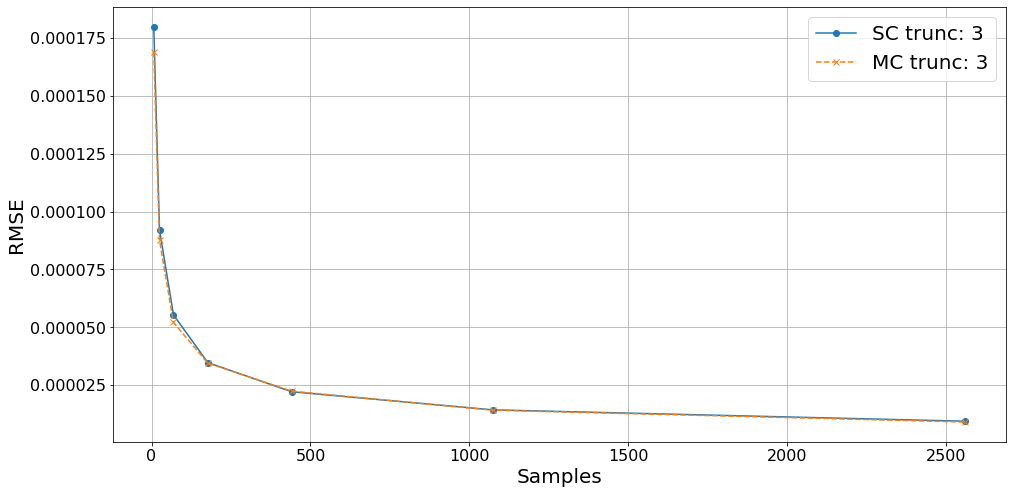

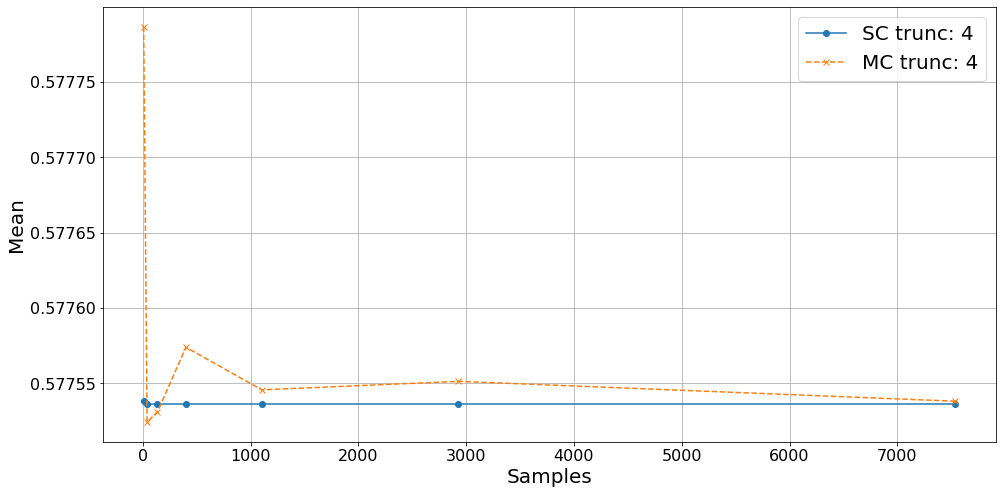

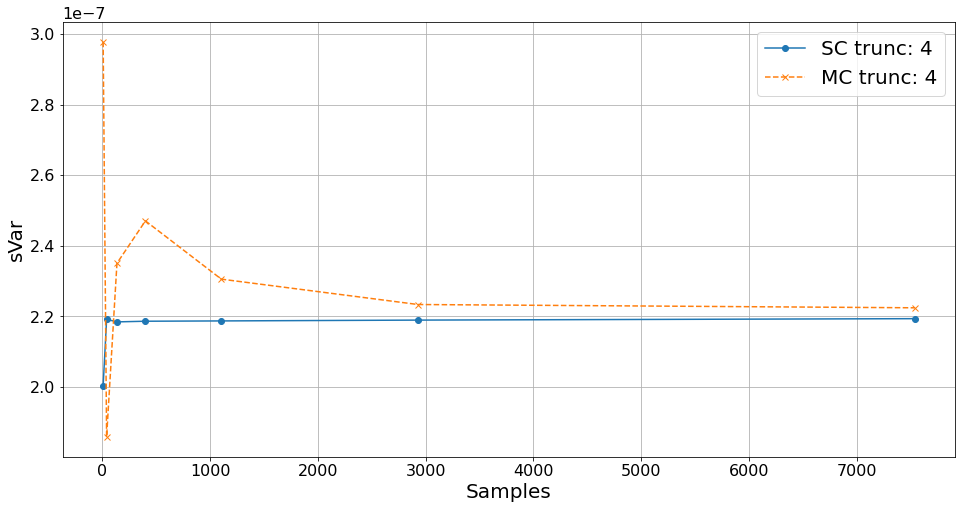

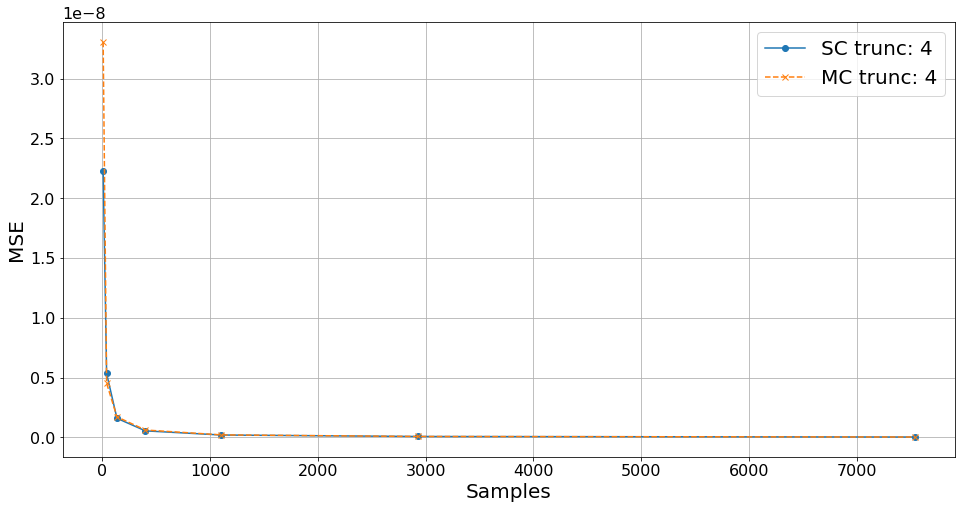

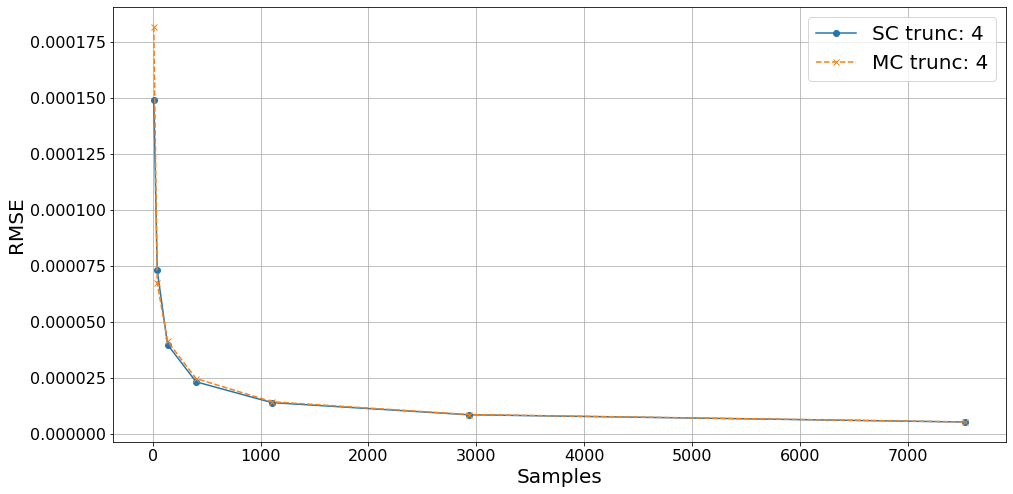

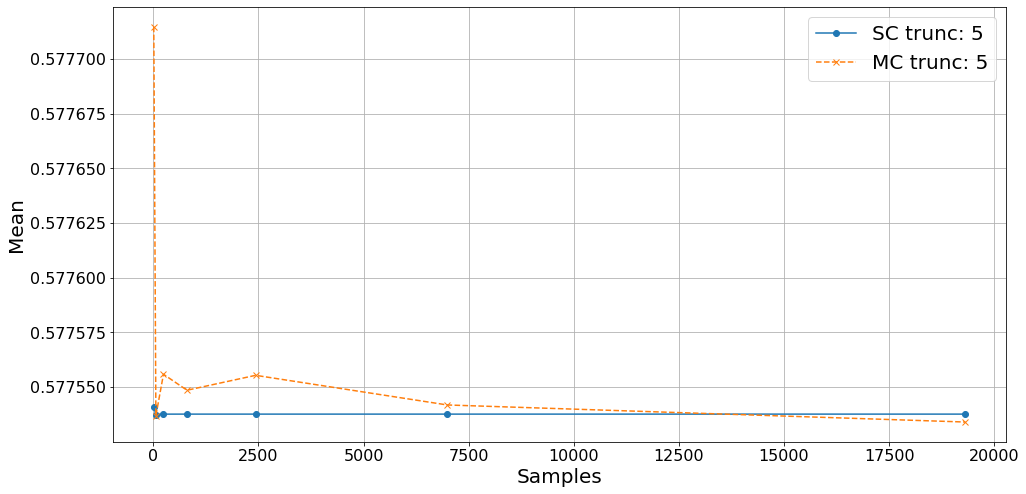

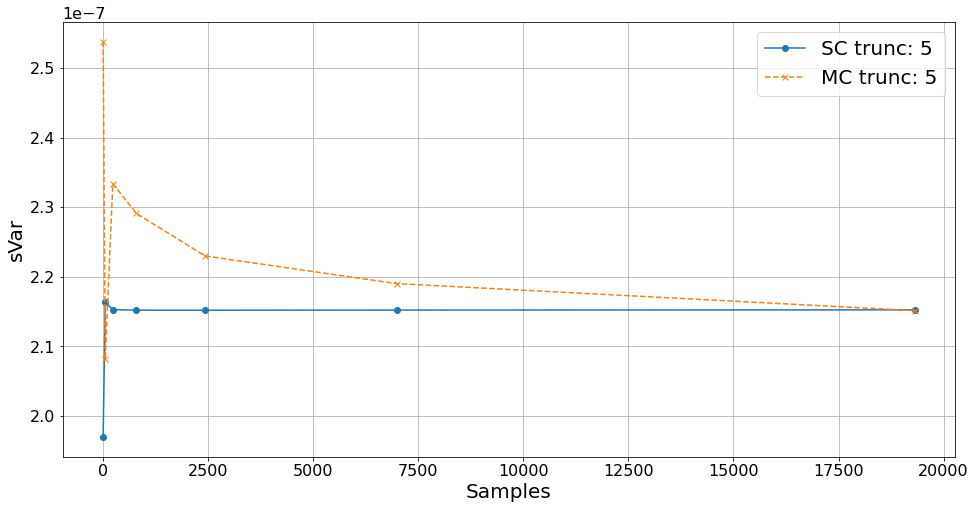

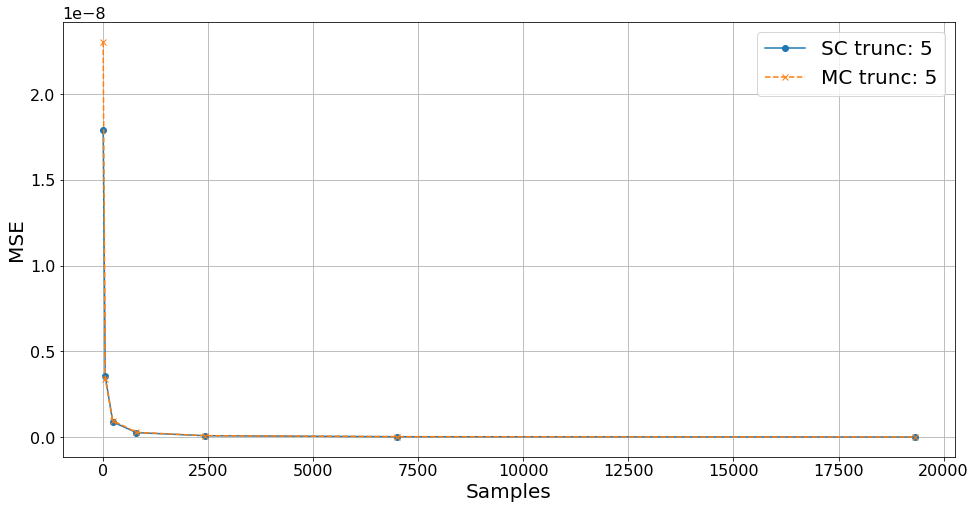

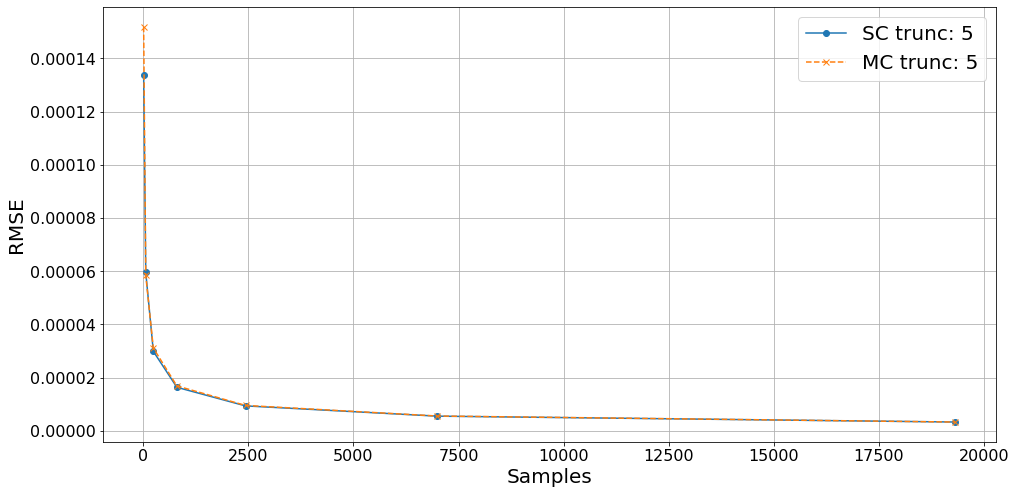

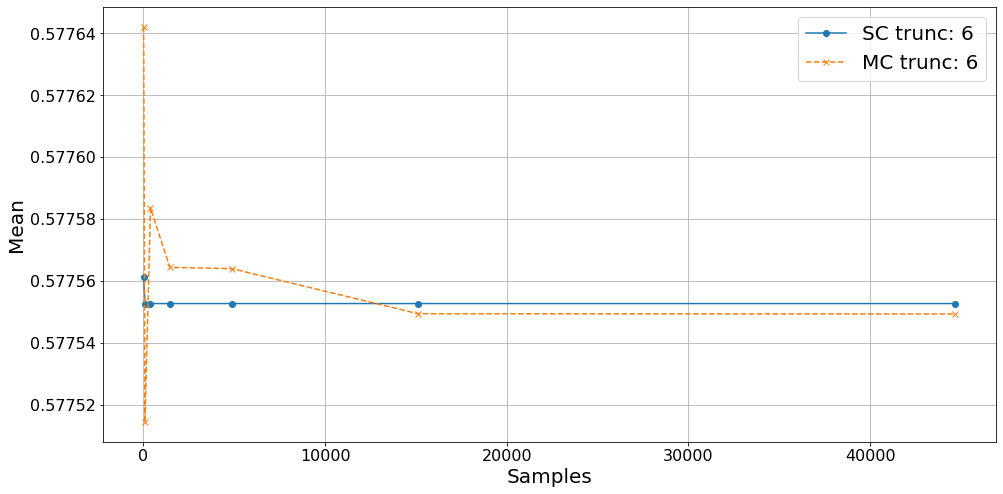

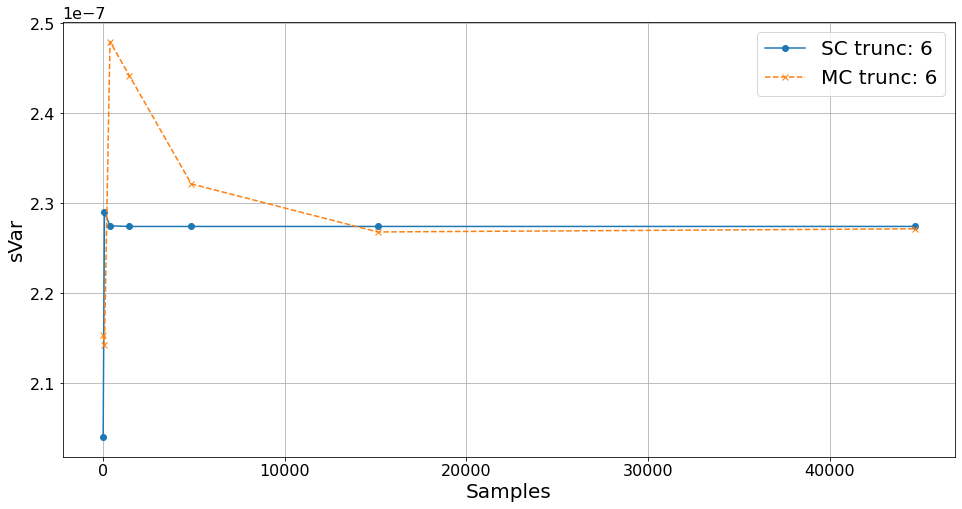

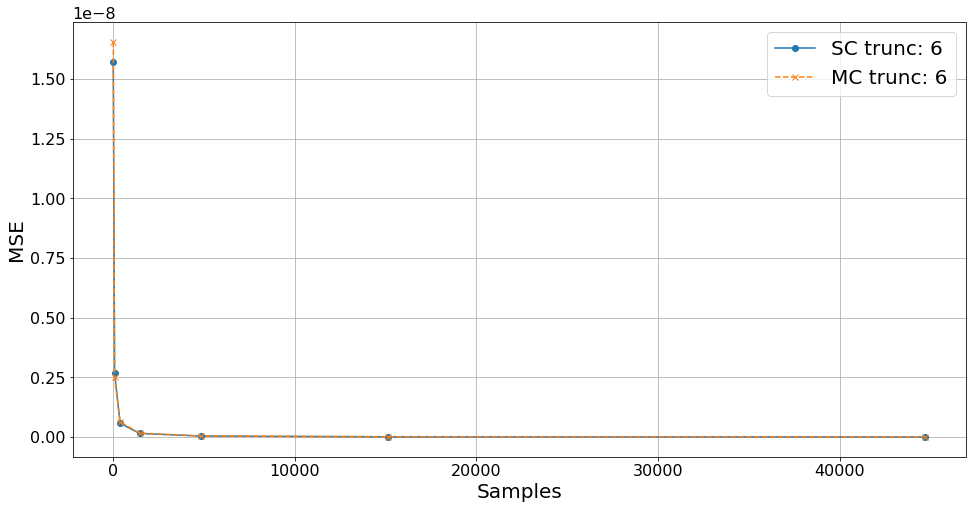

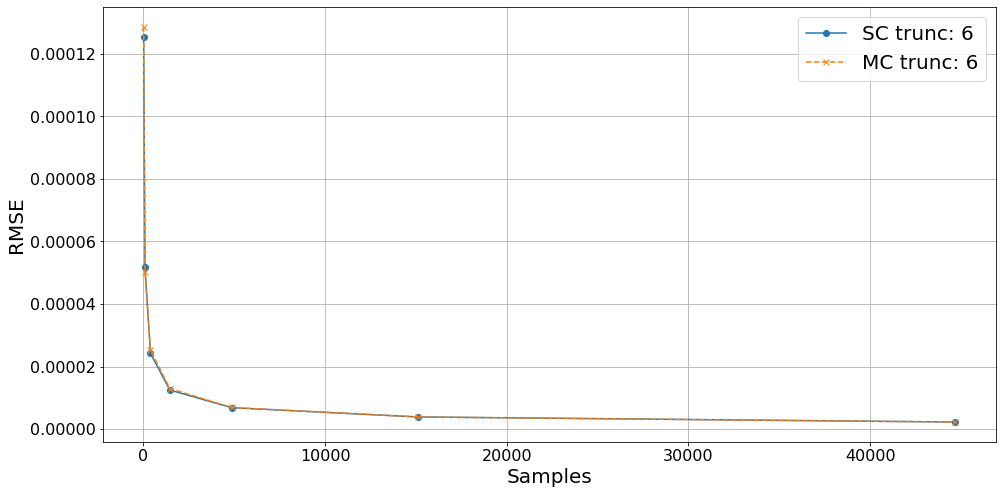

In [29]:
# Comparing for SpaceLevel=5
space_level = 5
trunc_values = [1,2,3,4,5,6]

for trunc in trunc_values:
    # Compare Mean
    #name = f"mean_trunc_{trunc}_stoch_level.png"
    #one_parameter_compare_stoch_level(df_sc_5, df_mc_5, "Mean", space_level, trunc, name)
    name = f"mean_trunc_{trunc}_sample_size.png"
    one_parameter_compare_sample_size(df_sc_5, df_mc_5, "Mean", space_level, trunc, name)

    # Compare sVar
    #name = f"svar_trunc_{trunc}_stoch_level.png"
    #one_parameter_compare_stoch_level(df_sc_5, df_mc_5, "sVar", space_level, trunc, name)
    name = f"svar_trunc_{trunc}_sample_size.png"
    one_parameter_compare_sample_size(df_sc_5, df_mc_5, "sVar", space_level, trunc, name)

    # Compare MSE
    #name = f"mse_trunc_{trunc}_stoch_level.png"
    #one_parameter_compare_stoch_level(df_sc_5, df_mc_5, "MSE", space_level, trunc, name)
    name = f"mse_trunc_{trunc}_sample_size.png"
    one_parameter_compare_sample_size(df_sc_5, df_mc_5, "MSE", space_level, trunc, name)

    # Compare RMSE
    #name = f"rmse_trunc_{trunc}_stoch_level.png"
    #one_parameter_compare_stoch_level(df_sc_5, df_mc_5, "RMSE", space_level, trunc, name)
    name = f"rmse_trunc_{trunc}_sample_size.png"
    one_parameter_compare_sample_size(df_sc_5, df_mc_5, "RMSE", space_level, trunc, name)

# Solution for different covariance kernels
Finally we aim to investigate the impact of various parameter choices in the covariance kernel defined by $C(x,y)=\sigma^2 \exp\left( \frac{-|x-y|_2^{\alpha}}{\lambda^{\alpha}} \right)$. Specifically, we will explore how changes in the parameters $\sigma$, $\alpha$, and $\lambda$ influence the results. We used a fixed SpaceLevel of $5$ and stochastic dimension $4$.

# Method to evaluate M++ data into DataFrames for different parameter values

In [3]:
sparse_grid_points = {
    '↓level\Trunc->': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    1: [3, 5, 9, 17, 33, 65, 129, 257, 513, 1025],
    2: [5, 13, 29, 65, 145, 321, 705, 1537, 3329, 7169],
    3: [7, 25, 69, 177, 441, 1073, 2561, 6017, 13953, 32001],
    4: [9, 41, 137, 401, 1105, 2929, 7537, 18945, 46721, 113409],
    5: [11, 61, 241, 801, 2433, 6993, 19313, 51713, 135073, 345665],
    6: [13, 85, 389, 1457, 4865, 15121, 44689, 127105, 350657, 943553],
    7: [15, 113, 589, 2465, 9017, 30241, 95441, 287745, 836769, 2362881],
    8: [17, 145, 849, 3937, 15713, 56737, 190881, 609025, 1863937, 5515265],
    9: [19, 181, 1177, 6001, 26017, 100897, 361249, 1218049, 3918273, 12133761],
    10: [21, 221, 1581, 8801, 41265, 171425, 652065, 2320385, 7836545, 25370753],
    20: [41, 841, 11561, 120401, 1018129, 7314609, 46106289, 0, 0, 0]
}

def eval_mpp_covarianz(trunc_values, stoch_levels, space_level, alpha, sigma, length):
    """
    This function evaluates MPP data for given truncation values, stochastic levels, 
    and covariance parameters (alpha, sigma, length), running the MPP simulation and 
    parsing the results into a DataFrame.

    Parameters:
    trunc_values (list): A list of truncation values to be used in the simulation.
    stoch_levels (list): A list of stochastic levels to be used in the simulation.
    space_level (int): The space level to be used in the simulation.
    alpha (float): The alpha parameter for the covariance function.
    sigma (float): The sigma parameter for the covariance function.
    length (float): The length parameter for the covariance function.

    Returns:
    pd.DataFrame: A DataFrame containing the results of the MPP simulation with columns:
                  "length", "alpha", "sigma", "trunc", "stochLevel", "Samples", 
                  "Mean", "sVar", "MSE", "RMSE".
    """
    
    mpp.mute = True
    mpp.reset_data()

    degree = 1
    SampleMethod = "SC"

    # Create columns for the DataFrame
    columns = [
        "length",
        "alpha",
        "sigma",
        "trunc",
        "stochLevel",
        "Samples",
        "Value",   # This column will be renamed from 'Value' later
        "sVar",
        "MSE",
        "RMSE",
        "level" # Column will be renamed to 'SpaceLevel' later
    ]
    
    # Iterate over truncation values
    for trunc in trunc_values:
        # Iterate over stochastic levels
        for L in tqdm(stoch_levels):
            kwargs = {
                "degree": degree,
                "SampleMethod": SampleMethod,
                "Estimator": SampleMethod,
                "Level": space_level,
                "level": space_level,
                "Samples": sparse_grid_points[trunc][L-1],
                "trunc": trunc,
                "stochLevel": L,
                "alpha": alpha,
                "sigma": sigma,
                "length": length,
                "VtuPlot": 0 #Very important for computational time
            }
            mpp.run(1, config="SC_elliptic", kwargs=kwargs)
            mpp.parse_log()

    # Create DataFrame from MPP data
    df = pd.DataFrame(mpp.data, columns=columns)
    
    # Rename
    df.rename(columns={'Value': 'Mean'}, inplace=True)
    df.rename(columns={'level': 'SpaceLevel'}, inplace=True)

    # Replace arrays in 'sVar' column with the second-to-last element of each array
    df['sVar'] = df['sVar'].apply(lambda x: x[-2] if isinstance(x, list) and len(x) >= 3 else None)
        
    return df

# Calculation of all required DataFrames for different parameter values with M++ (optional)

The next cell is optional. Note that the computation can take more than 2 hours depending on the system due to the lack of parallelization.
All DataFrames can be immediately loaded from the respective files in the directory using the Python module Pickle in the following cell.

In [ ]:
# Parameters
trunc_values = [4]
space_level = 5
stoch_levels = [1, 2, 3, 4, 5, 6]

# Lambda calculations
length_parameters = [0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6] # different lenghts
alpha = 1.0 # fixed alpha
sigma = 1.0 # fixed sigma

df_length = pd.DataFrame() # create DataFrame
for length in tqdm(length_parameters):
    new_df = eval_mpp_covarianz(trunc_values, stoch_levels, space_level, alpha, sigma, length)
    new_df['length'] = length
    new_df['alpha'] = alpha
    new_df['sigma'] = sigma
    df_length = pd.concat([df_length, new_df], ignore_index=True)
    
# Saving DataFrame length
file_path = 'DataFrames/df_length.pickle'
with open(file_path, 'wb') as file:
    pickle.dump(df_length, file)



# alpha calculations
length = 1.2 # fixed lamdba
alpha_parameters = [1, 1.2, 1.4, 1.6, 1.8] # different alpha values
sigma = 1.0 # fixed sigma

df_alpha = pd.DataFrame() # create DataFrame
for alpha in tqdm(alpha_parameters):
    new_df = eval_mpp_covarianz(trunc_values, stoch_levels, space_level, alpha, sigma, length)
    new_df['length'] = length
    new_df['alpha'] = alpha
    new_df['sigma'] = sigma
    df_alpha = pd.concat([df_alpha, new_df], ignore_index=True)

# Saving DataFrame alpha
file_path = 'DataFrames/df_alpha.pickle'
with open(file_path, 'wb') as file:
    pickle.dump(df_alpha, file)


# sigma calculations
length = 1 # fixed lamdba
alpha = 1 # fixed alpha
sigma_parameters = [0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6] # different sigma values

df_sigma = pd.DataFrame() # create DataFrame
for sigma in tqdm(sigma_parameters):
    new_df = eval_mpp_covarianz(trunc_values, stoch_levels, space_level, alpha, sigma, length)
    new_df['length'] = length
    new_df['alpha'] = alpha
    new_df['sigma'] = sigma
    df_sigma = pd.concat([df_sigma, new_df], ignore_index=True)

# Saving DataFrame sigma
file_path = 'DataFrames/df_sigma.pickle'
with open(file_path, 'wb') as file:
    pickle.dump(df_sigma, file)


# Loading from files of required DataFrames for different parameter values (optional)

To save computation time, all the required DataFrames can be loaded from the files in the next cell.

In [9]:
# Opening lamdba (length) file
file_path = 'DataFrames/df_length.pickle'
df_length = None
with open(file_path, 'rb') as file:
    # Deserialize and retrieve the variable from the file
    df_length = pickle.load(file)

# Opening alpha (smoothness) file
file_path = 'DataFrames/df_alpha.pickle'
df_alpha = None
with open(file_path, 'rb') as file:
    # Deserialize and retrieve the variable from the file
    df_alpha = pickle.load(file)

# Opening sigma (variance) file
file_path = 'DataFrames/df_sigma.pickle'
df_sigma = None
with open(file_path, 'rb') as file:
    # Deserialize and retrieve the variable from the file
    df_sigma = pickle.load(file)

# Calculation of all required DataFrames for convergence experiments for different parameter values with M++ (optional)

The next cell is optional. Please note that the computation may take more than 2 hours, depending on the system, due to the lack of parallelization. All DataFrames are located in the Python folder on GitHub. The analysis of this data has been performed outside of this notebook and can be reproduced using the resources available on GitHub.

In [4]:
# Parameters
trunc_values = [4]
stoch_levels = [2, 4]
length_parameters = [0.05, 0.075, 0.1, 0.125, 0.15]  # different lengths
alpha_parameters = [1, 1.2, 1.4, 1.8, 2.0]  # different alpha values
sigma_parameters = [1, 1.25, 1.5, 1.75, 2.0]  # different sigma values

# Loop over space levels
for space_level in range(1, 6):
    # Lambda calculations
    alpha = 1.0  # fixed alpha
    sigma = 1.0  # fixed sigma

    df_length = pd.DataFrame()  # create DataFrame
    for length in tqdm(length_parameters, desc=f'Length calculations for space_level={space_level}'):
        new_df = eval_mpp_covarianz(trunc_values, stoch_levels, space_level, alpha, sigma, length)
        new_df['length'] = length
        new_df['alpha'] = alpha
        new_df['sigma'] = sigma
        df_length = pd.concat([df_length, new_df], ignore_index=True)
    
    # Saving DataFrame length
    file_path = f'DataFrames/df_length_{space_level}.pickle'
    with open(file_path, 'wb') as file:
        pickle.dump(df_length, file)

    # Alpha calculations
    length = 0.05  # fixed lambda
    sigma = 1.0  # fixed sigma

    df_alpha = pd.DataFrame()  # create DataFrame
    for alpha in tqdm(alpha_parameters, desc=f'Alpha calculations for space_level={space_level}'):
        new_df = eval_mpp_covarianz(trunc_values, stoch_levels, space_level, alpha, sigma, length)
        new_df['length'] = length
        new_df['alpha'] = alpha
        new_df['sigma'] = sigma
        df_alpha = pd.concat([df_alpha, new_df], ignore_index=True)

    # Saving DataFrame alpha
    file_path = f'DataFrames/df_alpha_{space_level}.pickle'
    with open(file_path, 'wb') as file:
        pickle.dump(df_alpha, file)

    # Sigma calculations
    length = 0.05  # fixed lambda
    alpha = 1.0  # fixed alpha

    df_sigma = pd.DataFrame()  # create DataFrame
    for sigma in tqdm(sigma_parameters, desc=f'Sigma calculations for space_level={space_level}'):
        new_df = eval_mpp_covarianz(trunc_values, stoch_levels, space_level, alpha, sigma, length)
        new_df['length'] = length
        new_df['alpha'] = alpha
        new_df['sigma'] = sigma
        df_sigma = pd.concat([df_sigma, new_df], ignore_index=True)

    # Saving DataFrame sigma
    file_path = f'DataFrames/df_sigma_{space_level}.pickle'
    with open(file_path, 'wb') as file:
        pickle.dump(df_sigma, file)


Sigma calculations for space_level=5: 100%|███████| 5/5 [05:57<00:00, 71.45s/it]


# Plotting sVar for different parameters

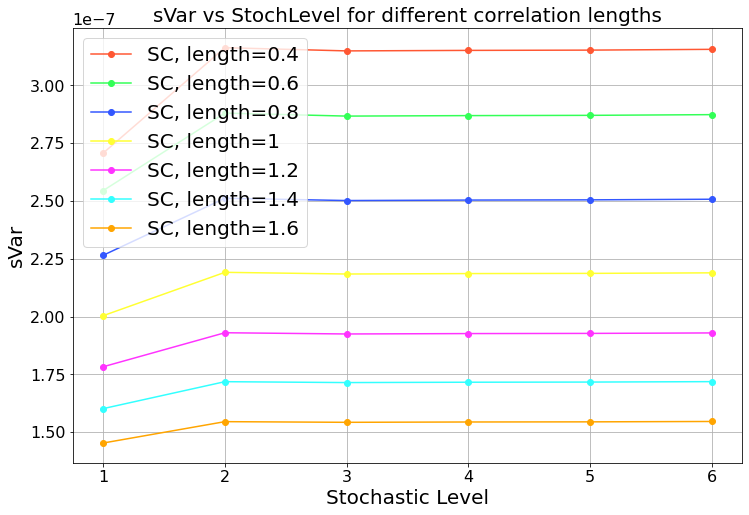

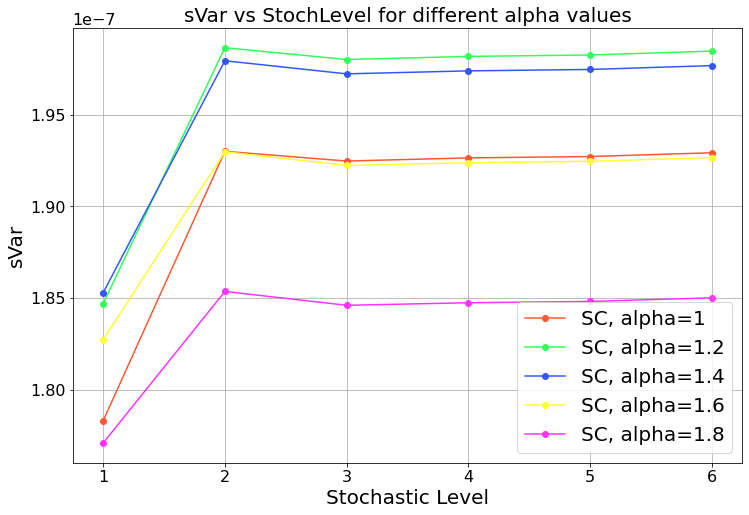

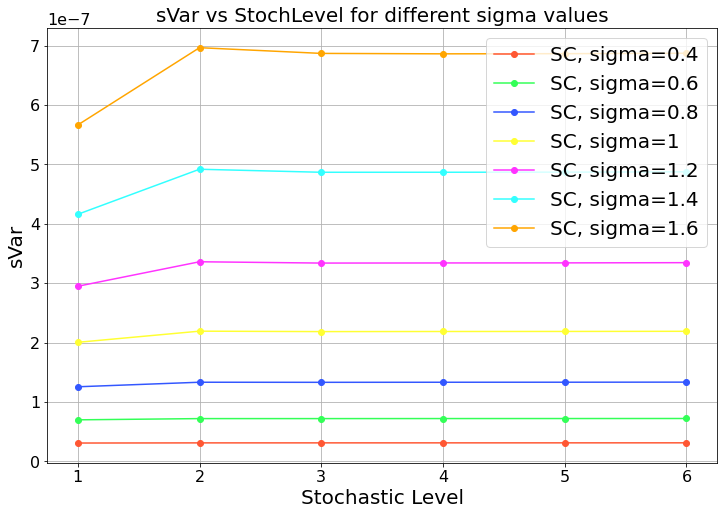

In [32]:
# Parameter values
length_parameters = [0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6] 
alpha_parameters = [1, 1.2, 1.4, 1.6, 1.8]
sigma_parameters = [0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6]
stoch_levels = [1, 2, 3, 4, 5, 6]

# Plotting variables
colors = [
    "#FF5733",  # Bright Red
    "#33FF57",  # Bright Green
    "#3357FF",  # Bright Blue
    "#FFFF33",  # Bright Yellow
    "#FF33FF",  # Bright Magenta
    "#33FFFF",  # Bright Cyan
    "#FFA500",  # Orange
    "#800080",  # Purple
    "#808080"   # Gray
]
label_fontsize = 20
tick_fontsize = 16


# length plot
plt.figure(figsize=(12, 8))

for length, color in zip(length_parameters, colors):
    subset = df_length[df_length['length'] == length]
    plt.plot(subset['stochLevel'].values, subset['sVar'].values, label=f'SC, length={length}', marker='o', color=color)

plt.title('sVar vs StochLevel for different correlation lengths', fontsize=label_fontsize)
plt.xlabel('Stochastic Level', fontsize=label_fontsize)
plt.ylabel('sVar', fontsize=label_fontsize)
plt.legend(fontsize=label_fontsize)
plt.grid(True)
plt.xticks(stoch_levels, fontsize=tick_fontsize)
plt.yticks(fontsize=tick_fontsize)
ax = plt.gca()
ax.yaxis.get_offset_text().set_fontsize(tick_fontsize)
plt.savefig("sVar_length.png", dpi=500)
plt.show()


# alpha plot
plt.figure(figsize=(12, 8))

for alpha, color in zip(alpha_parameters, colors):
    subset = df_alpha[df_alpha['alpha'] == alpha]
    plt.plot(subset['stochLevel'].values, subset['sVar'].values, label=f'SC, alpha={alpha}', marker='o', color=color)

plt.title('sVar vs StochLevel for different alpha values', fontsize=label_fontsize)
plt.xlabel('Stochastic Level', fontsize=label_fontsize)
plt.ylabel('sVar', fontsize=label_fontsize)
plt.legend(fontsize=label_fontsize)
plt.grid(True)
plt.xticks(stoch_levels, fontsize=tick_fontsize)
plt.yticks(fontsize=tick_fontsize)
ax = plt.gca()
ax.yaxis.get_offset_text().set_fontsize(tick_fontsize)
plt.savefig("sVar_alpha.png", dpi=500)
plt.show()


# sigma plot
plt.figure(figsize=(12, 8))

for sigma, color in zip(sigma_parameters, colors):
    subset = df_sigma[df_sigma['sigma'] == sigma]
    plt.plot(subset['stochLevel'].values, subset['sVar'].values, label=f'SC, sigma={sigma}', marker='o', color=color)

plt.title('sVar vs StochLevel for different sigma values', fontsize=label_fontsize)
plt.xlabel('Stochastic Level', fontsize=label_fontsize)
plt.ylabel('sVar', fontsize=label_fontsize)
plt.legend(fontsize=label_fontsize)
plt.grid(True)
plt.xticks(stoch_levels, fontsize=tick_fontsize)
plt.yticks(fontsize=tick_fontsize)
ax = plt.gca()
ax.yaxis.get_offset_text().set_fontsize(tick_fontsize)
plt.savefig("sVar_sigma.png", dpi=500)
plt.show()


# Plotting MSE for different parameters

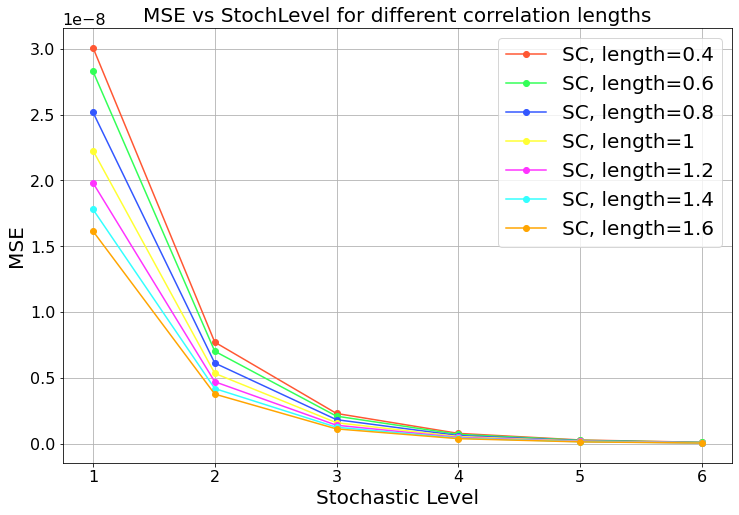

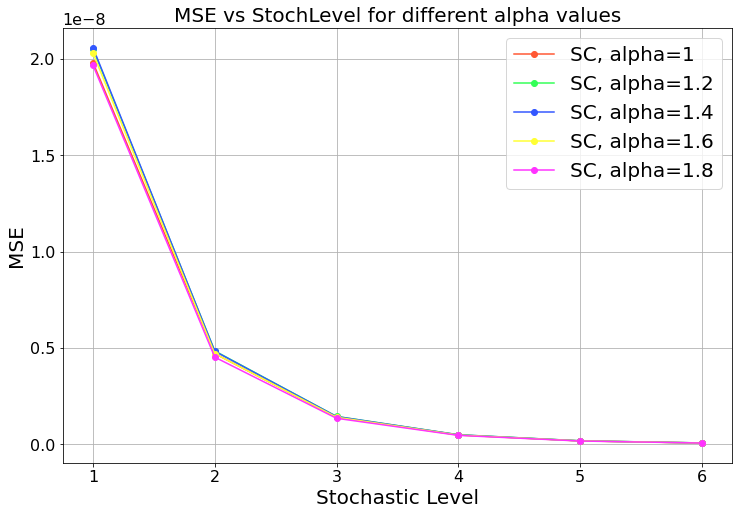

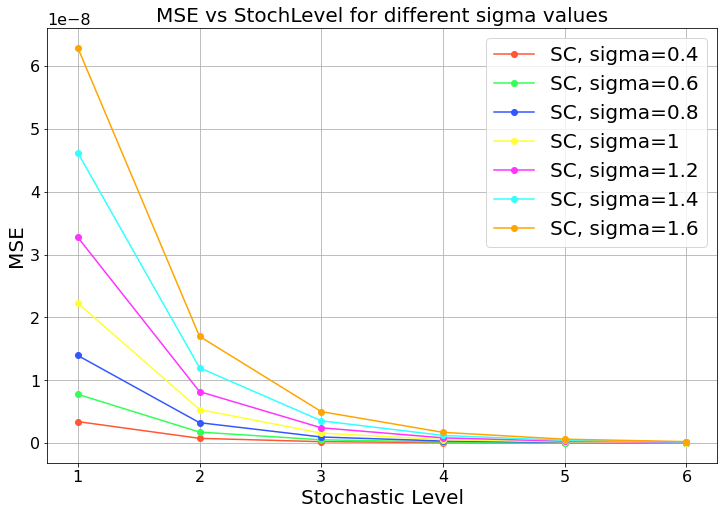

In [33]:
# length plot
plt.figure(figsize=(12, 8))

for length, color in zip(length_parameters, colors):
    subset = df_length[df_length['length'] == length]
    plt.plot(subset['stochLevel'].values, subset['MSE'].values, label=f'SC, length={length}', marker='o', color=color)

plt.title('MSE vs StochLevel for different correlation lengths', fontsize=label_fontsize)
plt.xlabel('Stochastic Level', fontsize=label_fontsize)
plt.ylabel('MSE', fontsize=label_fontsize)
plt.legend(fontsize=label_fontsize)
plt.grid(True)
plt.xticks(stoch_levels, fontsize=tick_fontsize)
plt.yticks(fontsize=tick_fontsize)
ax = plt.gca()
ax.yaxis.get_offset_text().set_fontsize(tick_fontsize)
plt.savefig("MSE_length.png", dpi=500)
plt.show()


# alpha plot
plt.figure(figsize=(12, 8))

for alpha, color in zip(alpha_parameters, colors):
    subset = df_alpha[df_alpha['alpha'] == alpha]
    plt.plot(subset['stochLevel'].values, subset['MSE'].values, label=f'SC, alpha={alpha}', marker='o', color=color)

plt.title('MSE vs StochLevel for different alpha values', fontsize=label_fontsize)
plt.xlabel('Stochastic Level', fontsize=label_fontsize)
plt.ylabel('MSE', fontsize=label_fontsize)
plt.legend(fontsize=label_fontsize)
plt.grid(True)
plt.xticks(stoch_levels, fontsize=tick_fontsize)
plt.yticks(fontsize=tick_fontsize)
ax = plt.gca()
ax.yaxis.get_offset_text().set_fontsize(tick_fontsize)
plt.savefig("MSE_alpha.png", dpi=500)
plt.show()


# sigma plot
plt.figure(figsize=(12, 8))

for sigma, color in zip(sigma_parameters, colors):
    subset = df_sigma[df_sigma['sigma'] == sigma]
    plt.plot(subset['stochLevel'].values, subset['MSE'].values, label=f'SC, sigma={sigma}', marker='o', color=color)

plt.title('MSE vs StochLevel for different sigma values', fontsize=label_fontsize)
plt.xlabel('Stochastic Level', fontsize=label_fontsize)
plt.ylabel('MSE', fontsize=label_fontsize)
plt.legend(fontsize=label_fontsize)
plt.grid(True)
plt.xticks(stoch_levels, fontsize=tick_fontsize)
plt.yticks(fontsize=tick_fontsize)
ax = plt.gca()
ax.yaxis.get_offset_text().set_fontsize(tick_fontsize)
plt.savefig("MSE_sigma.png", dpi=500)
plt.show()

# Plotting RMSE for different parameters

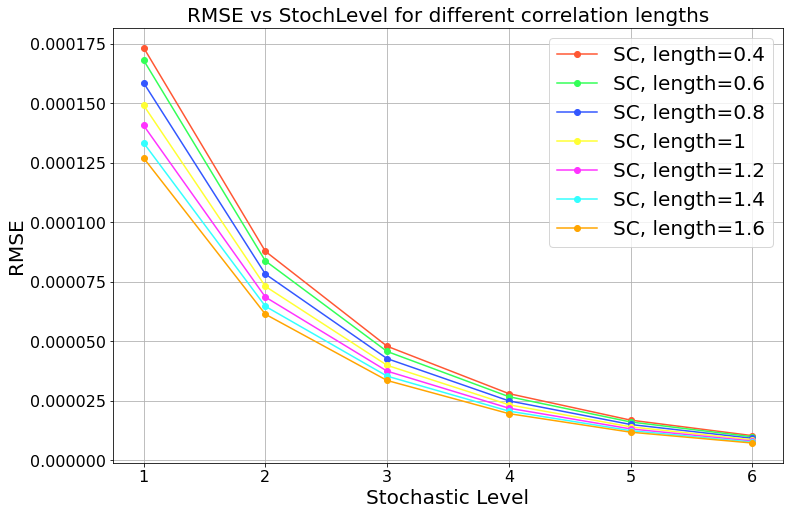

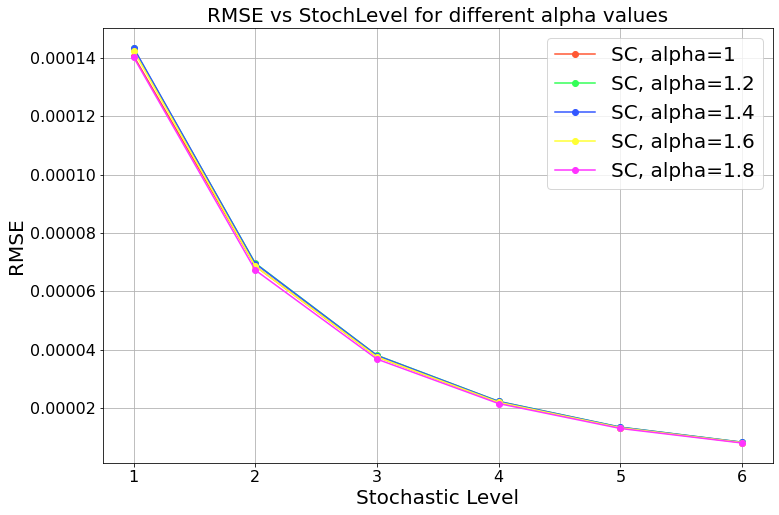

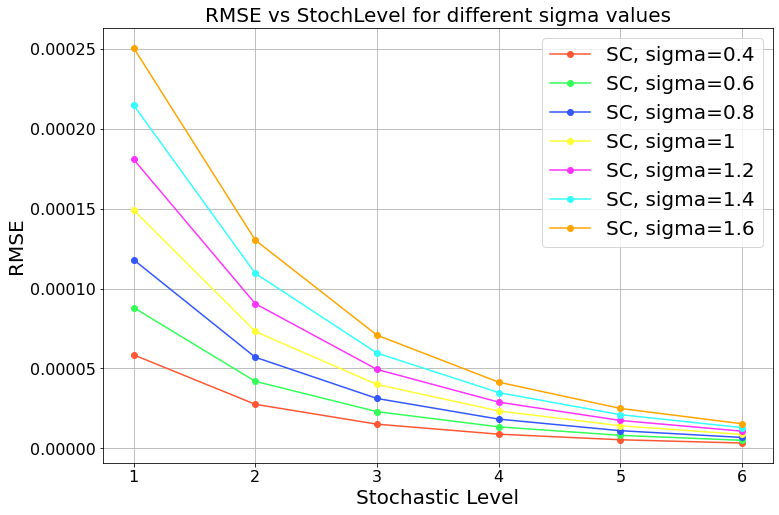

In [34]:
# length plot
plt.figure(figsize=(12, 8))

for length, color in zip(length_parameters, colors):
    subset = df_length[df_length['length'] == length]
    plt.plot(subset['stochLevel'].values, subset['RMSE'].values, label=f'SC, length={length}', marker='o', color=color)

plt.title('RMSE vs StochLevel for different correlation lengths', fontsize=label_fontsize)
plt.xlabel('Stochastic Level', fontsize=label_fontsize)
plt.ylabel('RMSE', fontsize=label_fontsize)
plt.legend(fontsize=label_fontsize)
plt.grid(True)
plt.xticks(stoch_levels, fontsize=tick_fontsize)
plt.yticks(fontsize=tick_fontsize)
ax = plt.gca()
ax.yaxis.get_offset_text().set_fontsize(tick_fontsize)
plt.savefig("RMSE_length.png", dpi=500)
plt.show()


# alpha plot
plt.figure(figsize=(12, 8))

for alpha, color in zip(alpha_parameters, colors):
    subset = df_alpha[df_alpha['alpha'] == alpha]
    plt.plot(subset['stochLevel'].values, subset['RMSE'].values, label=f'SC, alpha={alpha}', marker='o', color=color)

plt.title('RMSE vs StochLevel for different alpha values', fontsize=label_fontsize)
plt.xlabel('Stochastic Level', fontsize=label_fontsize)
plt.ylabel('RMSE', fontsize=label_fontsize)
plt.legend(fontsize=label_fontsize)
plt.grid(True)
plt.xticks(stoch_levels, fontsize=tick_fontsize)
plt.yticks(fontsize=tick_fontsize)
ax = plt.gca()
ax.yaxis.get_offset_text().set_fontsize(tick_fontsize)
plt.savefig("RMSE_alpha.png", dpi=500)
plt.show()


# sigma plot
plt.figure(figsize=(12, 8))

for sigma, color in zip(sigma_parameters, colors):
    subset = df_sigma[df_sigma['sigma'] == sigma]
    plt.plot(subset['stochLevel'].values, subset['RMSE'].values, label=f'SC, sigma={sigma}', marker='o', color=color)

plt.title('RMSE vs StochLevel for different sigma values', fontsize=label_fontsize)
plt.xlabel('Stochastic Level', fontsize=label_fontsize)
plt.ylabel('RMSE', fontsize=label_fontsize)
plt.legend(fontsize=label_fontsize)
plt.grid(True)
plt.xticks(stoch_levels, fontsize=tick_fontsize)
plt.yticks(fontsize=tick_fontsize)
ax = plt.gca()
ax.yaxis.get_offset_text().set_fontsize(tick_fontsize)
plt.savefig("RMSE_sigma.png", dpi=500)
plt.show()

In [ ]:
# Parameters
trunc_values = [3]
space_level = 4
stoch_levels = [1, 2, 3, 4]

# Lambda calculations
length_parameters = [0.05, 0.075, 0.1] # different lenghts
alpha = 1.4 # fixed alpha
sigma = 1.0 # fixed sigma

df_length_new = pd.DataFrame() # create DataFrame
for length in tqdm(length_parameters):
    new_df = eval_mpp_covarianz(trunc_values, stoch_levels, space_level, alpha, sigma, length)
    print(new_df)
    new_df['length'] = length
    new_df['alpha'] = alpha
    new_df['sigma'] = sigma
    df_length_new = pd.concat([df_length_new, new_df], ignore_index=True)
    print("Length =", length, "done")
    
    
# Saving DataFrame length
file_path = 'DataFrames/df_length_new.pickle'
with open(file_path, 'wb') as file:
    pickle.dump(df_length_new, file)



# alpha calculations
length = 0.05 # fixed lenght
alpha_parameters = [1.0, 1.4, 1.8] # different alphas
sigma = 1.0 # fixed sigma

df_alpha_new = pd.DataFrame() # create DataFrame
for alpha in tqdm(alpha_parameters):
    new_df = eval_mpp_covarianz(trunc_values, stoch_levels, space_level, alpha, sigma, length)
    print(new_df)
    new_df['length'] = length
    new_df['alpha'] = alpha
    new_df['sigma'] = sigma
    df_alpha_new = pd.concat([df_alpha_new, new_df], ignore_index=True)
    print("Alpha =", alpha, "done")
    
    
# Saving DataFrame length
file_path = 'DataFrames/df_alpha_new.pickle'
with open(file_path, 'wb') as file:
    pickle.dump(df_alpha_new, file)

 75%|█████████████████████████████████▊           | 3/4 [00:15<00:06,  6.18s/it]

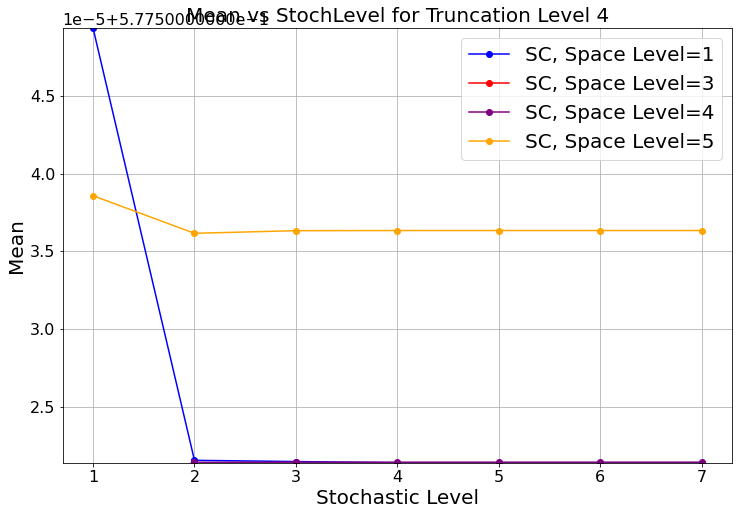

In [22]:
#Filter the DataFrames for trunc=4
df_sc_1_trunc6 = df_sc_1[df_sc_1['trunc'] == 4]
df_sc_2_trunc6 = df_sc_2[df_sc_2['trunc'] == 4]
df_sc_3_trunc6 = df_sc_3[df_sc_3['trunc'] == 4]
df_sc_4_trunc6 = df_sc_4[df_sc_4['trunc'] == 4]
df_sc_5_trunc6 = df_sc_5[df_sc_5['trunc'] == 4]

# Create plot
plt.figure(figsize=(12, 8))

# Plot for SpaceLevel=1
plt.plot(df_sc_1_trunc6['stochLevel'].values, df_sc_1_trunc6['Mean'].values, label=f'SC, Space Level={1}', marker='o', color='blue')

# Plot for SpaceLevel=2
#plt.plot(df_sc_2_trunc6['stochLevel'].values, df_sc_2_trunc6['Mean'].values, label=f'SC, Space Level={2}', marker='o', color='green')

# Plot for SpaceLevel=3
plt.plot(df_sc_3_trunc6['stochLevel'].values, df_sc_3_trunc6['Mean'].values, label=f'SC, Space Level={3}', marker='o', color='red')

# Plot for SpaceLevel=4
plt.plot(df_sc_4_trunc6['stochLevel'].values, df_sc_4_trunc6['Mean'].values, label=f'SC, Space Level={4}', marker='o', color='purple')

# Plot for SpaceLevel=5
plt.plot(df_sc_5_trunc6['stochLevel'].values, df_sc_5_trunc6['Mean'].values, label=f'SC, Space Level={5}', marker='o', color='orange')


#plt.title(f'Mean vs StochLevel for Truncation Level {4}', fontsize=label_fontsize)
plt.xlabel('Stochastic Level', fontsize=label_fontsize)
plt.ylabel('Mean', fontsize=label_fontsize)
plt.legend(fontsize=label_fontsize)
plt.grid(True)
plt.xticks([1,2,3,4,5,6,7], fontsize=tick_fontsize)

plt.yticks(fontsize=tick_fontsize)
ax = plt.gca()
ax.yaxis.get_offset_text().set_fontsize(tick_fontsize)
plt.savefig("Mean_different_space_levels_no_2_trunc_4.png", dpi=500)
plt.show()